# Problem Statement

## Context

### Problem Statement

The Campaign is used to get user to open a term deposit, but if the marketing team reaches out to every single user it will cost a lot resources. Therefore to increases it's efectifity the marketing team would like to filter and contact only high percentage user to open a term deposit.

### Goals

Based on the Problem Statement the marketing team would like have the ability to predict the likelihood of a user to open a term deposit or not, so they can target the campaign to the one that are predicted to say yes. Not only that the bank would also like to learn what variables that would make the user want to open a term deposit.

### Analytic Approach

To make a prediction on the user likelihood to open a term deposit, first we need to analyze the data to help find some insight and the see the characteristics or pattern of those to want or do not want to open a term deposit. After the pattern is found, then we are going to build a classificaion model that will help the marketing team to predict the likelihood of a user to open a term deposit.

### Evaluation Metrics

![Alt text](<image/me-revised.png>)

Type 1 error : False Positive

Consequence : Waste of marketing cost, time and resouces

Type 2 error : False Negative

Consequence : Losing potential user.

In [1]:
# Library

import pandas as pd
import numpy as np
import optuna

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
from IPython.display import display
from plotnine import *
import plotnine

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as stats
from sklearn.feature_selection import RFE, RFECV

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, matthews_corrcoef,precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics


# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


# Data Understanding

Data Source : https://archive.ics.uci.edu/ml/datasets/bank+marketing

Bank Marketing Campaign


A dataset is describing the result of a campaign for a bank in Portugal. This campaign is done by telemarketing, to offer user to open a term deposit. If the user agree the the target variable will be filled with 'yes' if not then 'no'

Feature description

Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
#Load Dataset
df = pd.read_csv('data-bank.csv',sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
display(df.describe(), df.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[84, 61]"
1,job,object,0,0.0,12,"[retired, management]"
2,marital,object,0,0.0,4,"[single, married]"
3,education,object,0,0.0,8,"[basic.6y, high.school]"
4,default,object,0,0.0,3,"[no, yes]"
5,housing,object,0,0.0,3,"[yes, unknown]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[nov, oct]"
9,day_of_week,object,0,0.0,5,"[mon, fri]"


## Explaratory Data Analysis

## Distribution

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


## Correlation

In [8]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [9]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.00,0.52,0.42,0.24,0.24,0.00,0.02,0.13,0.29,0.06,0.00,0.00,0.18,0.13,0.18,0.27,0.26,0.36,0.29,0.30,0.22
job,0.52,1.00,0.38,0.67,0.32,0.02,0.02,0.16,0.26,0.03,0.02,0.00,0.18,0.13,0.22,0.33,0.30,0.25,0.29,0.34,0.20
marital,0.42,0.38,1.00,0.25,0.10,0.01,0.00,0.11,0.08,0.01,0.00,0.00,0.06,0.07,0.04,0.10,0.11,0.12,0.15,0.11,0.08
education,0.24,0.67,0.25,1.00,0.26,0.02,0.00,0.16,0.20,0.03,0.00,0.00,0.07,0.06,0.07,0.12,0.20,0.13,0.18,0.13,0.09
default,0.24,0.32,0.10,0.26,1.00,0.04,0.01,0.08,0.19,0.02,0.00,0.04,0.05,0.12,0.24,0.35,0.33,0.23,0.24,0.31,0.06
housing,0.00,0.02,0.01,0.02,0.04,1.00,0.94,0.05,0.09,0.02,0.00,0.05,0.00,0.03,0.06,0.12,0.16,0.07,0.08,0.10,0.01
loan,0.02,0.02,0.00,0.00,0.01,0.94,1.00,0.01,0.03,0.01,0.00,0.05,0.00,0.00,0.00,0.03,0.04,0.02,0.02,0.02,0.00
contact,0.13,0.16,0.11,0.16,0.08,0.05,0.01,1.00,0.77,0.04,0.04,0.07,0.18,0.32,0.15,0.63,0.67,0.54,0.62,0.68,0.23
month,0.29,0.26,0.08,0.20,0.19,0.09,0.03,0.77,1.00,0.16,0.07,0.10,0.31,0.26,0.37,0.85,0.89,0.94,0.80,0.83,0.36
day_of_week,0.06,0.03,0.01,0.03,0.02,0.02,0.01,0.04,0.16,1.00,0.02,0.03,0.01,0.00,0.02,0.05,0.09,0.11,0.22,0.07,0.02


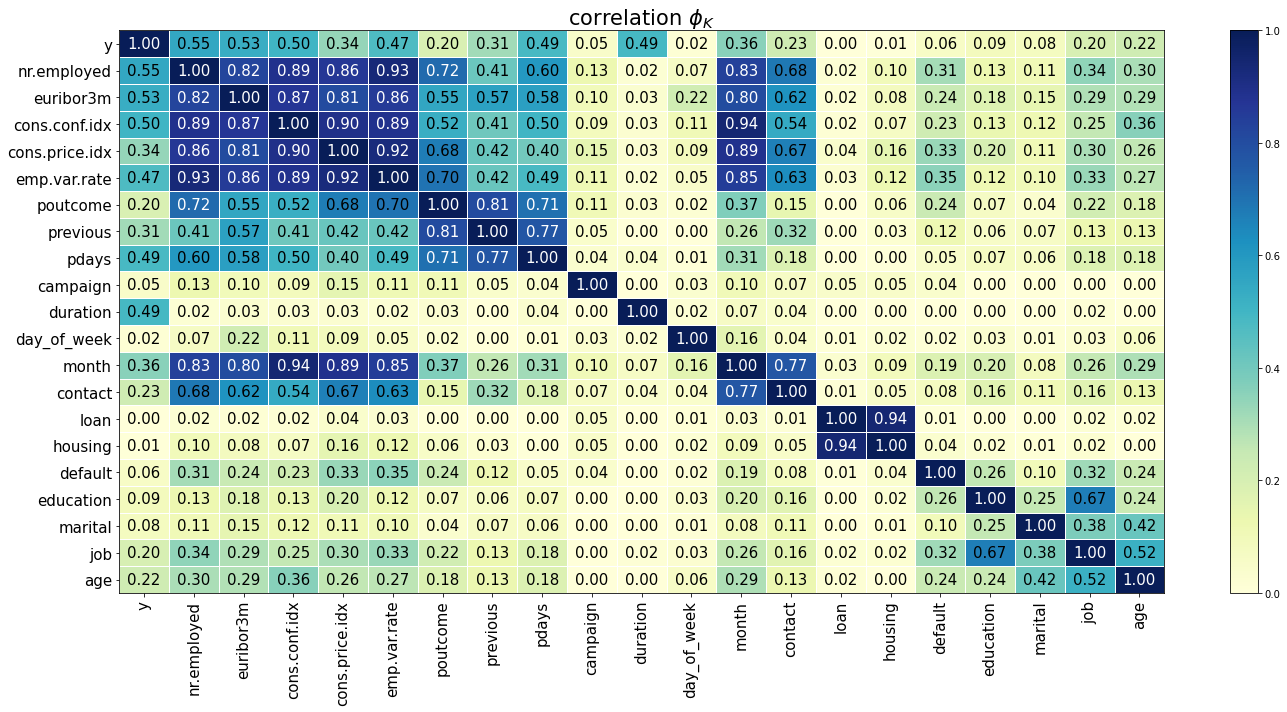

In [10]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

## Data Cardinality

In [11]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[33, 51]"
1,job,object,0,0.0,12,"[unemployed, management]"
2,marital,object,0,0.0,4,"[single, divorced]"
3,education,object,0,0.0,8,"[basic.6y, basic.9y]"
4,default,object,0,0.0,3,"[unknown, yes]"
5,housing,object,0,0.0,3,"[no, unknown]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[cellular, telephone]"
8,month,object,0,0.0,10,"[may, jun]"
9,day_of_week,object,0,0.0,5,"[mon, wed]"


## Duplicated Data

In [12]:
print(df[df.duplicated(keep=False)].shape)
df[df.duplicated(keep=False)]

(24, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


There are 24 column with the same value.

In [13]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Turning UNKNOWN values to Nan

In [14]:
list_unknown = []
cat_unknown = []
pct_unk = []
for cat in df.columns:
    if df[cat].dtype == 'object':
        cat_unknown.append(cat)
        list_unknown.append([cat,df[cat][df[cat] == 'unknown'].count(),f'{(df[cat][df[cat] == "unknown"].count()/df[cat].count() * 100).round(2)} %'])
        pct_unk.append(df[cat][df[cat] == 'unknown'].count())

df_unknown = pd.DataFrame(columns=['Column','f Unknown','Unknown %'],data =list_unknown)

df_unknown.sort_values(by = ['f Unknown'],ascending=False)

,Column,f Unknown,Unknown %
3,default,8597,20.87 %
2,education,1731,4.2 %
4,housing,990,2.4 %
5,loan,990,2.4 %
0,job,330,0.8 %
1,marital,80,0.19 %
6,contact,0,0.0 %
7,month,0,0.0 %
8,day_of_week,0,0.0 %
9,poutcome,0,0.0 %


Shows number of rows and percentage of unknown data in each categorical column.

In [15]:
# Replace 'unknown' with NaN in multiple columns
df = df.replace({'unknown': pd.np.nan})

Turn Unknown to Nan

### Visualisasi Nan dengan MissingNo Library

*To learn more about the library visit : https://github.com/ResidentMario/missingno*

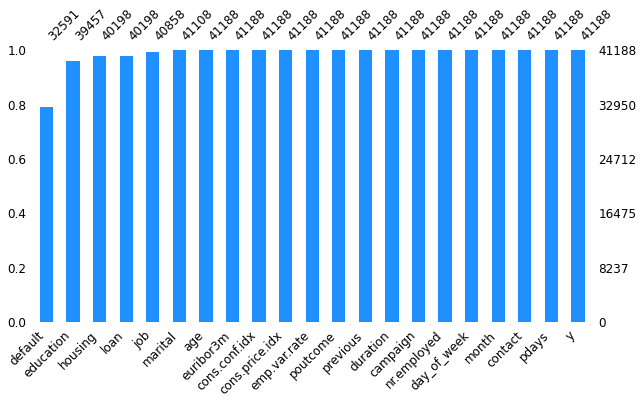

In [16]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

It is shown that default, education, housing, loan, job and marital has row with Nan.

<AxesSubplot:>

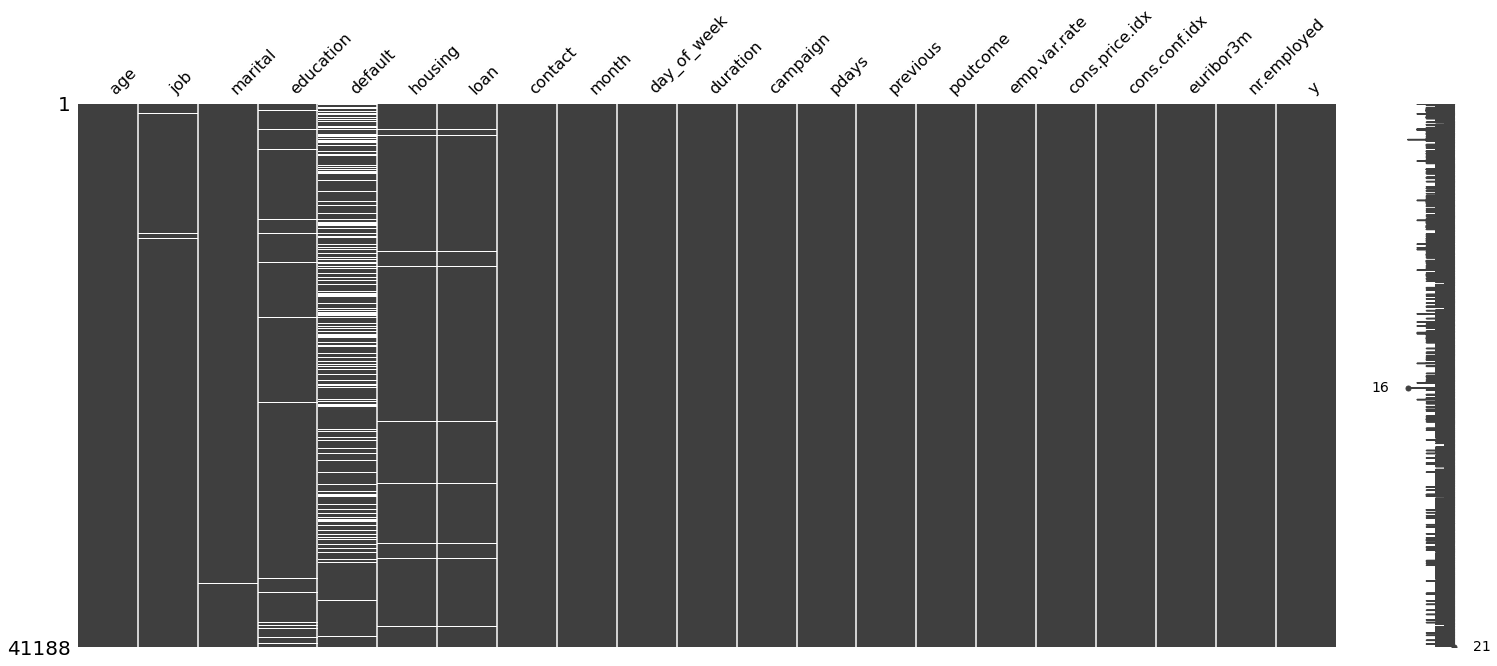

In [17]:
missingno.matrix(df)

<AxesSubplot:>

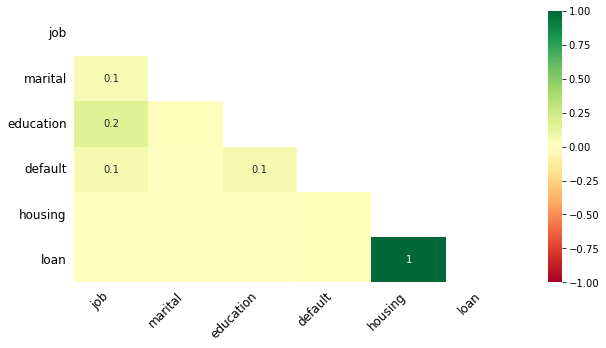

In [18]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12)

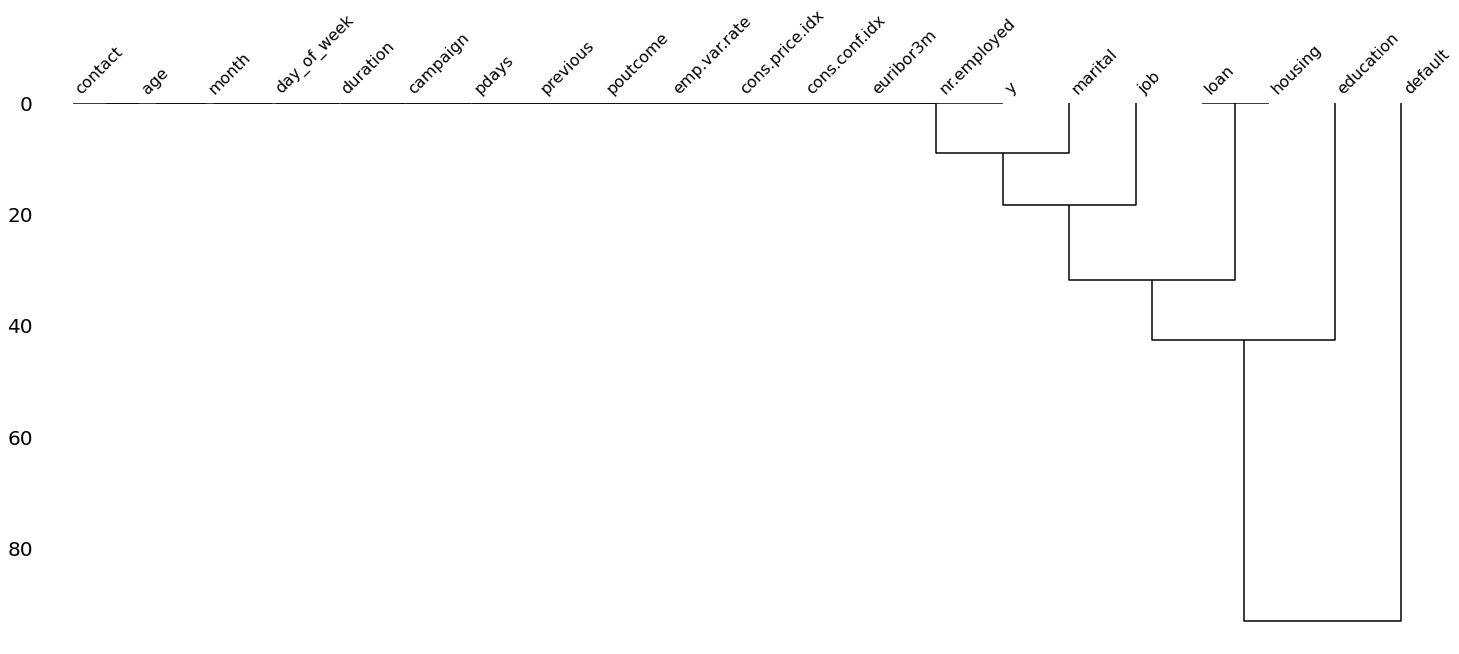

In [19]:
missingno.dendrogram(df)
plt.show()

Based on the plots above with can concur that : 

* Loan and housing has Nan values in the same row
* Default Column has more than 20% Nan values

## Check Outlier

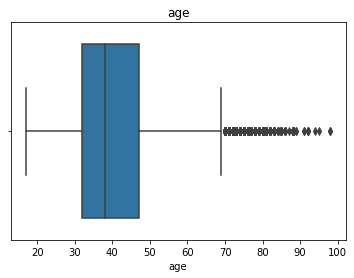

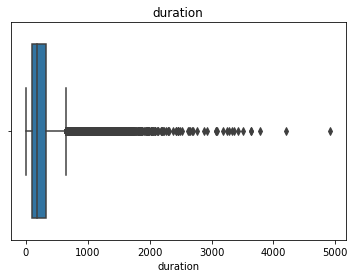

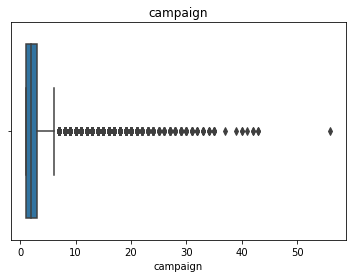

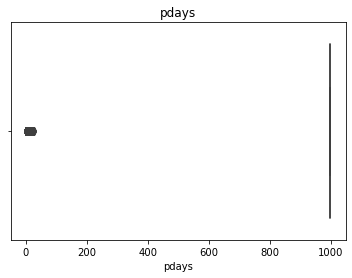

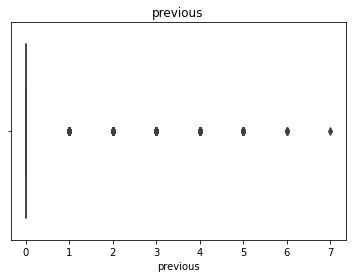

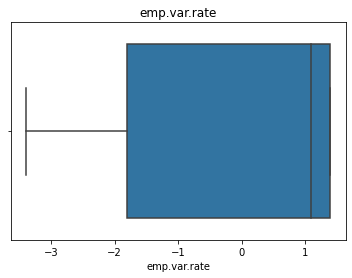

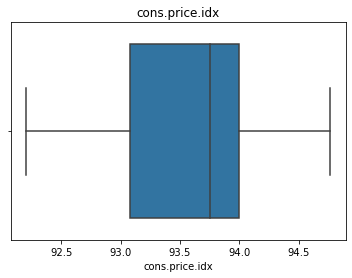

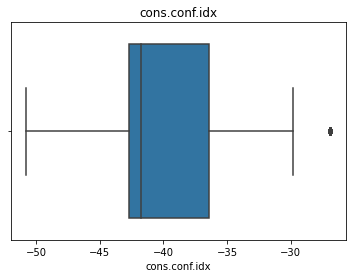

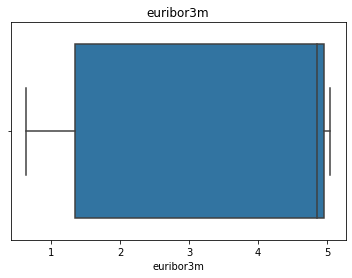

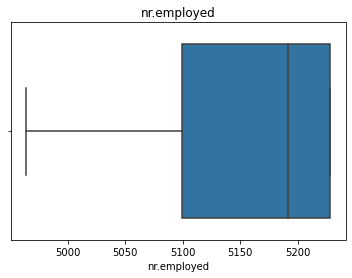

In [20]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# create boxplots for numerical columns
for col in num_cols:
    plt.figure()
    sns.boxplot(data=df, x=col)
    plt.title(col)


In [21]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89], dtype=int64)

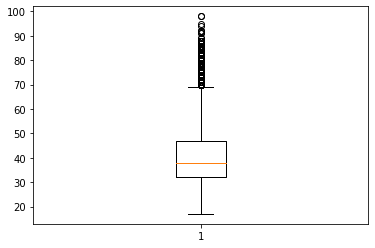

In [22]:
plt.boxplot(df['age'])
plt.show()

In [23]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print(f"Number of Outlier in Age Column : {len(outliers)}")


Number of Outlier in Age Column : 469


In [24]:
out_all=outliers.pivot_table(columns='age', index=['y'], aggfunc='size')
out_all['Total']=out_all.sum(axis =1)
out_all.sort_values('Total',ascending=False)

age,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,91,92,94,95,98,Total
y,,,,,,,,,,,,,,,,,,,,,,,,,,
no,28.0,32.0,21.0,21.0,17.0,13.0,16.0,7.0,13.0,7.0,13.0,12.0,6.0,9.0,4.0,8.0,3.0,NaN,13.0,NaN,2.0,1.0,1.0,1.0,NaN,248.0
yes,19.0,21.0,13.0,13.0,15.0,11.0,18.0,13.0,14.0,7.0,18.0,8.0,11.0,8.0,3.0,7.0,5.0,1.0,9.0,2.0,NaN,3.0,NaN,NaN,2.0,221.0


In [25]:
df['y'] = df['y'].replace({'yes': 1, 'no': 0})


replace data y with 1 = yes and 0 = no

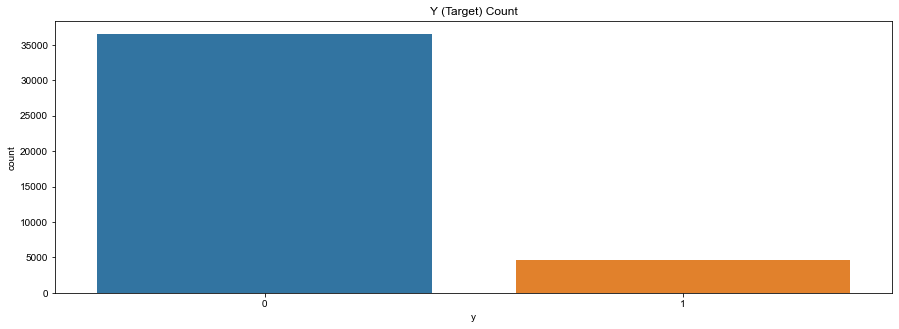

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(x='y', data=df)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Y (Target) Count')
plt.show()

Based on the visualization above of the target data, it is shown that the dataset highly imbalance.

### Numerical Columns

#### Job

Text(0.5, 1.0, 'Job Count')

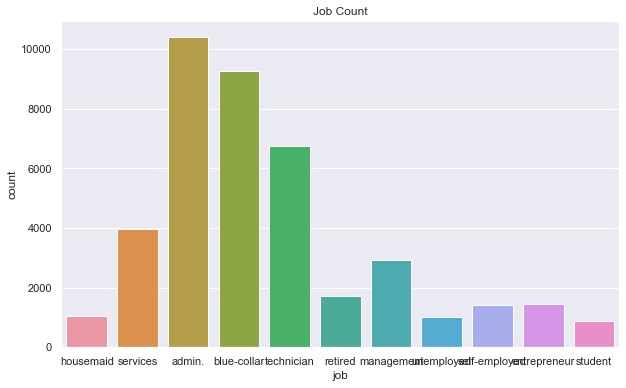

In [27]:
sns.countplot(data = df, x = 'job')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Job Count')

Text(0.5, 1.0, 'Job Count Based on Target')

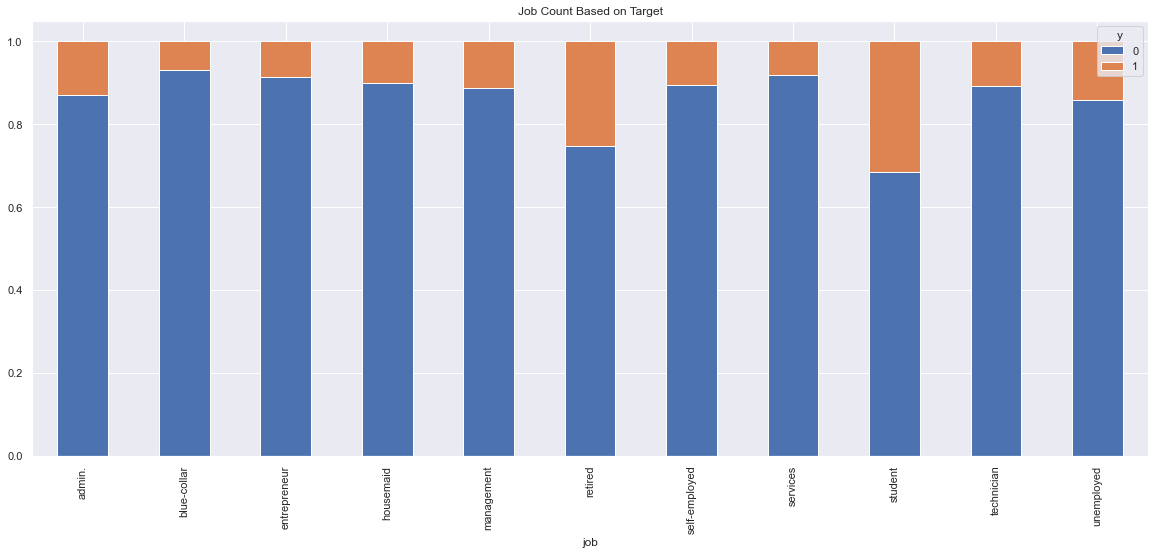

In [28]:
Job=pd.crosstab(df["job"],df['y'])
Job.div(Job.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,8))
plt.title('Job Count Based on Target')

Based on the visualization above it is shown that student and retired have the highest accepatance rate to opening a term deposit.

#### Poutcome

Text(0.5, 1.0, 'P Outcome Count')

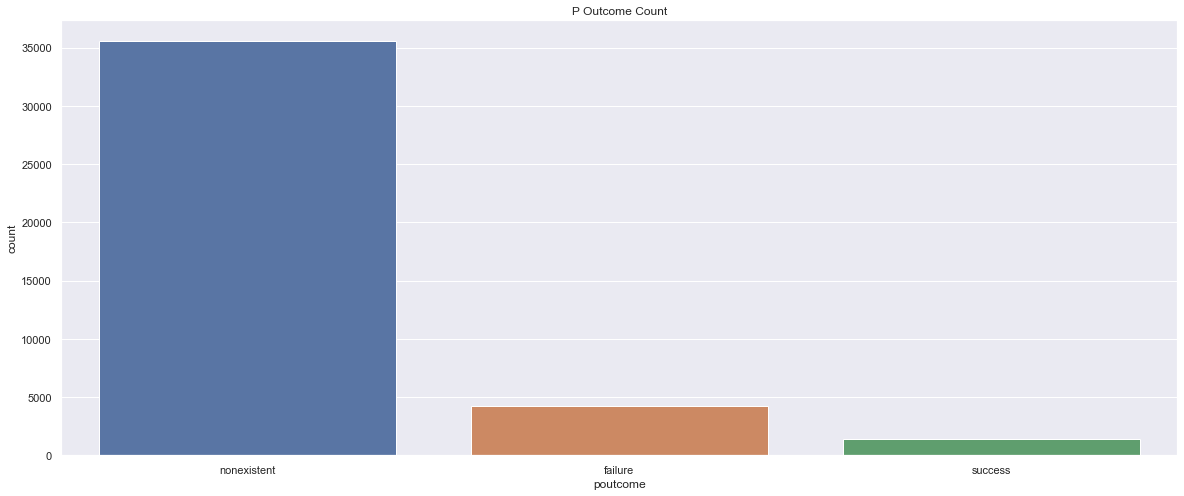

In [29]:
sns.countplot(data = df, x = 'poutcome')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count')

Text(0.5, 1.0, 'P Outcome Count Based on Target')

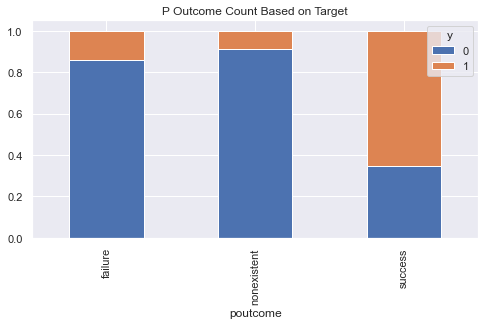

In [30]:
Poutcome=pd.crosstab(df["poutcome"],df['y'])
Poutcome.div(Poutcome.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count Based on Target')

Based on the visualization above it is shown that those whose previous campaign was categorize success has a higher chance to open a term deposit. 

#### Day of the week

Text(0.5, 1.0, 'Day of the Week Count')

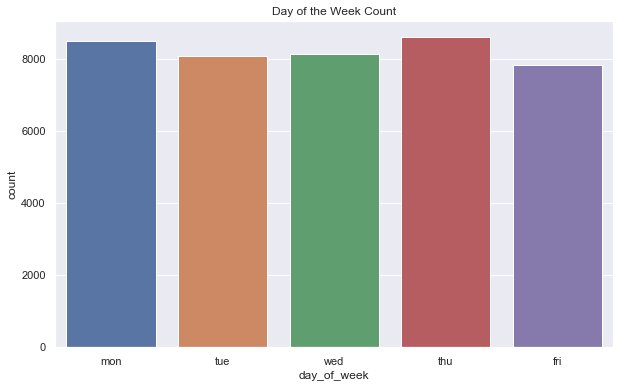

In [31]:
sns.countplot(data = df, x = 'day_of_week')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count')

Text(0.5, 1.0, 'Day of the Week Count Based on Target')

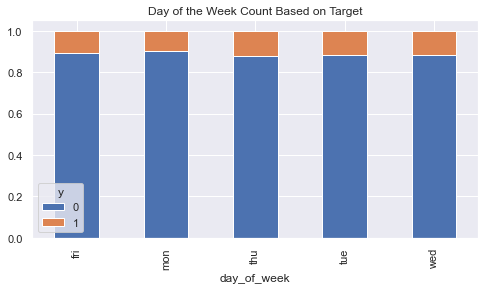

In [32]:
Day=pd.crosstab(df["day_of_week"],df['y'])
Day.div(Day.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count Based on Target')

Based on the visualization above it is shown that the campaign was only done in weekdays.

#### Month

Text(0.5, 1.0, 'Month Count')

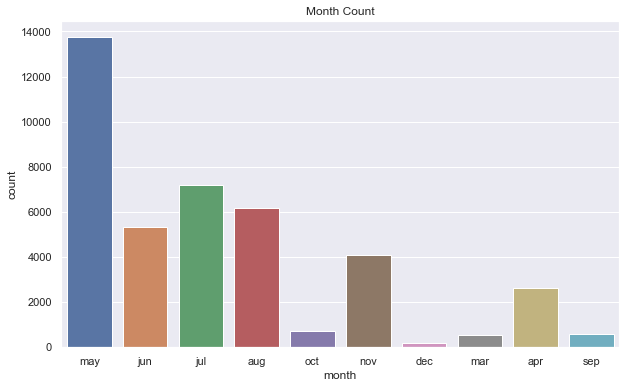

In [33]:
sns.countplot(data = df, x = 'month')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Month Count')

Text(0.5, 1.0, 'Month Count Based on Target')

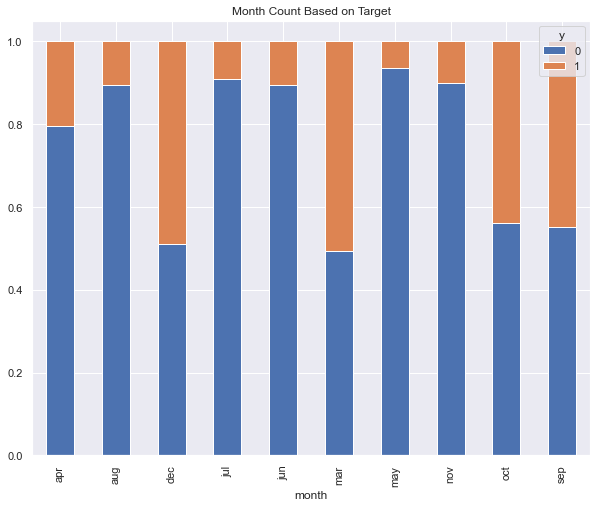

In [34]:
Month=pd.crosstab(df["month"],df['y'])
Month.div(Month.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))
plt.title('Month Count Based on Target')

Based on the visualizatoin above it is shown that the highest number of offer was done in May, and yet the highest number of acceptance rate was shown in March, October, September and December.

#### Contact

Text(0.5, 1.0, 'Contact Count')

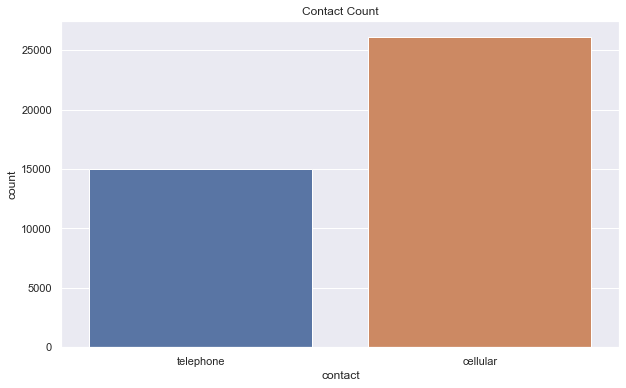

In [35]:
sns.countplot(data = df, x = 'contact')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count')

Text(0.5, 1.0, 'Contact Count Based on Target')

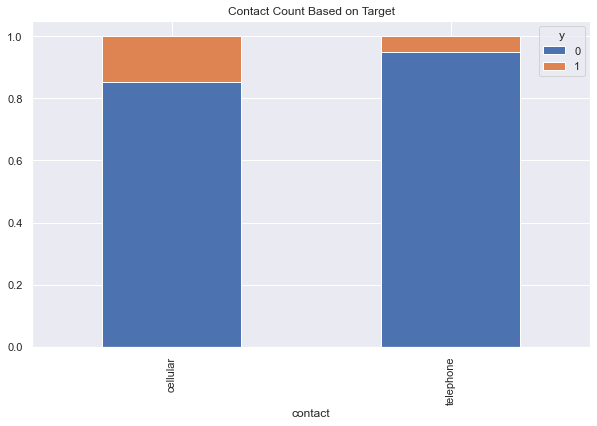

In [36]:
Contact=pd.crosstab(df["contact"],df['y'])
Contact.div(Contact.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count Based on Target')

#### Marital

Text(0.5, 1.0, 'Marital Count')

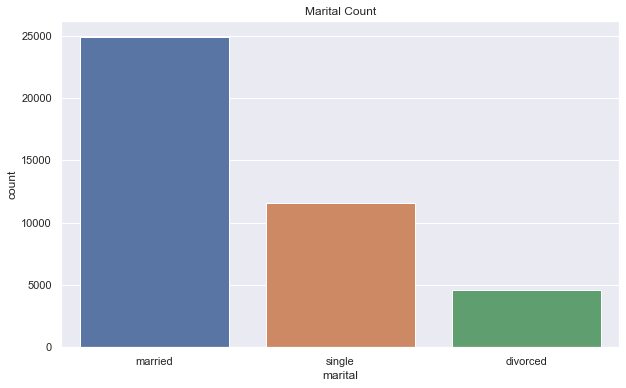

In [37]:
sns.countplot(data = df, x = 'marital')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count')

Text(0.5, 1.0, 'Marital Count Based on Target')

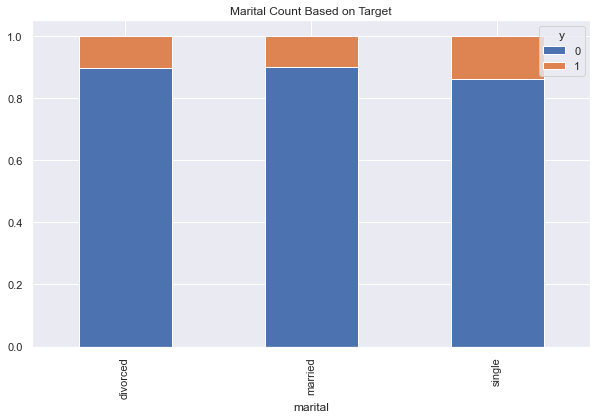

In [38]:
Marital=pd.crosstab(df["marital"],df['y'])
Marital.div(Marital.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count Based on Target')

Based on the visualization above it is shown that the user that is categorize as Married is contacted more but the one categorize as single has a higher chance to open a term deposit.

#### Loan

Text(0.5, 1.0, 'Loan Count')

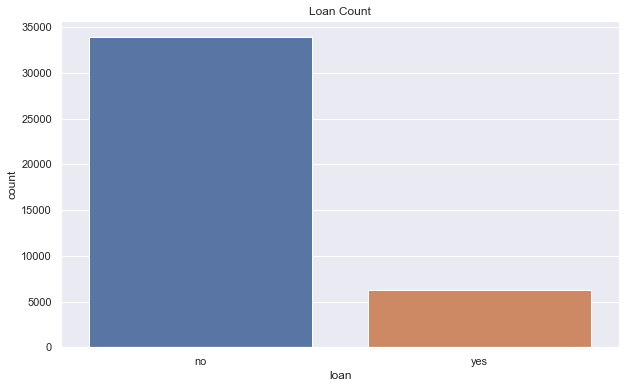

In [39]:
sns.countplot(data = df, x = 'loan')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Loan Count')

Text(0.5, 1.0, 'Loan Count Based on Target')

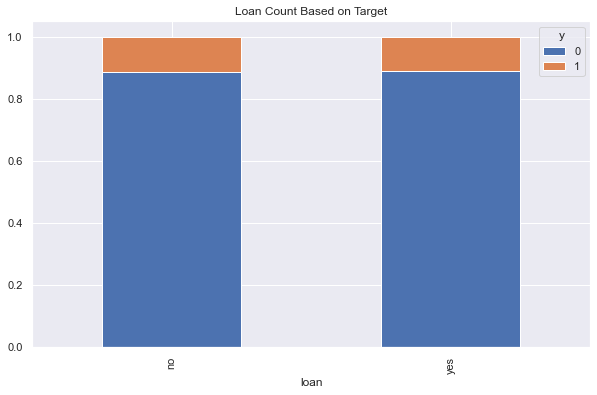

In [40]:
Loan=pd.crosstab(df["loan"],df['y'])
Loan.div(Loan.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Loan Count Based on Target')

Based on the visualization above it is shown that those that are categorize as no is contacted more, but there are no significant difference in those that have or did not have loan.

#### Housing

Text(0.5, 1.0, 'Housing Count')

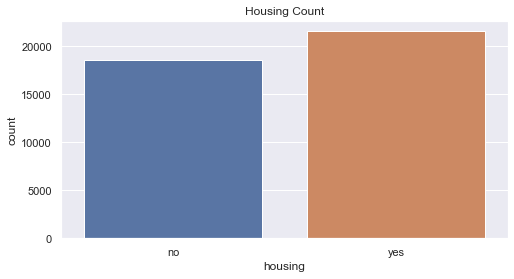

In [41]:
sns.countplot(data = df, x = 'housing')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count')

Text(0.5, 1.0, 'Housing Count Based on Target')

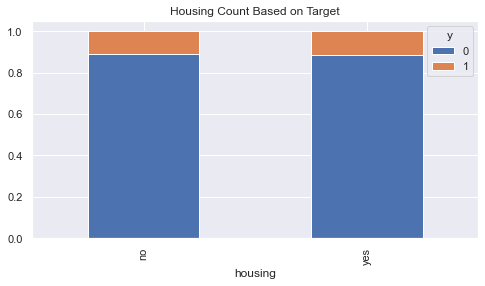

In [42]:
Housing=pd.crosstab(df["housing"],df['y'])
Housing.div(Housing.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count Based on Target')

Based on the visualization above it is shown that those that are categorize as yes is contacted more, but there are no significant difference in those that have or did not have housing loan.

#### Default

Text(0.5, 1.0, 'Default Count')

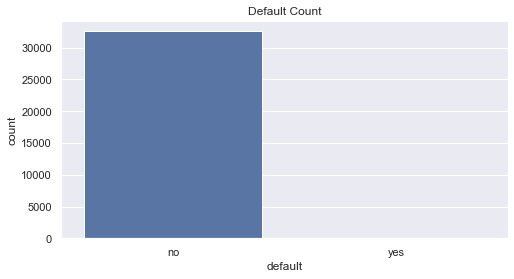

In [43]:
sns.countplot(data = df, x = 'default')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count')

Text(0.5, 1.0, 'Default Count Based on Target')

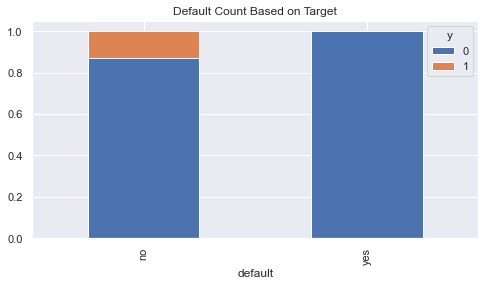

In [44]:
Default=pd.crosstab(df["default"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count Based on Target')

Based on the visualization above it is shown that those who are categorize as yes did not open a term deposit.

#### Education

Text(0.5, 1.0, 'Education')

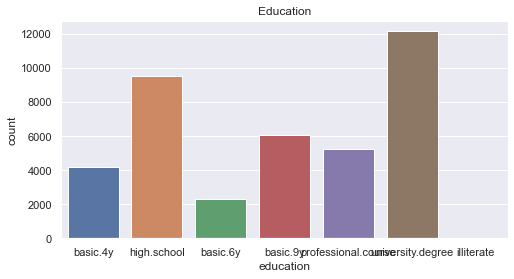

In [45]:
sns.countplot(data = df, x = 'education')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Education')

Text(0.5, 1.0, 'Education Count Based on Target')

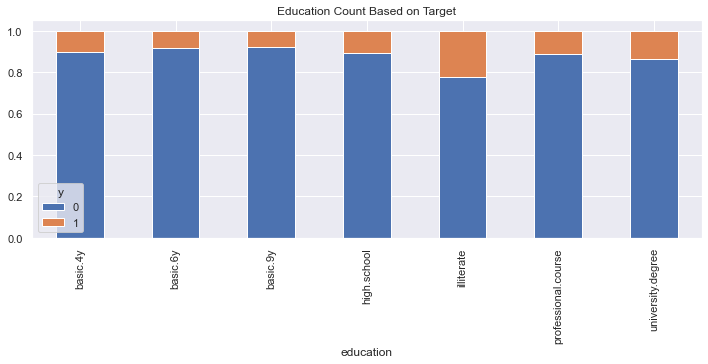

In [46]:
Default=pd.crosstab(df["education"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(12,4))
plt.title('Education Count Based on Target')

Based on the visualization above it is shown that illeterate has the highest chances to open a term deposit.

### Numerical Features

In [47]:
num_column = []
lst_nunique = []
for cat in df.columns:
    if df[cat].dtype != 'object' and cat != 'y' :
        num_column.append(cat)
        lst_nunique.append([cat,df[cat].nunique()])

df_num = pd.DataFrame(columns=['Column','f Unique'],data =lst_nunique)

df_num


,Column,f Unique
0,age,78
1,duration,1544
2,campaign,42
3,pdays,27
4,previous,8
5,emp.var.rate,10
6,cons.price.idx,26
7,cons.conf.idx,26
8,euribor3m,316
9,nr.employed,11


#### Number of Employees

Text(0.5, 1.0, 'Number of Employees Distribution based on target')

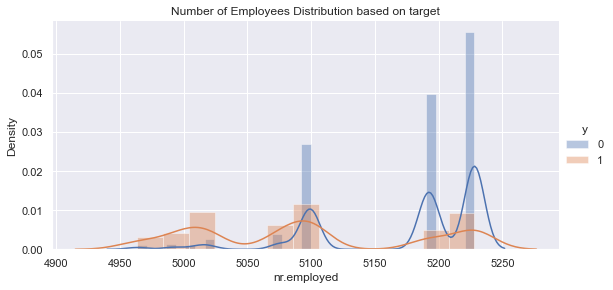

In [48]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'nr.employed').add_legend()
plt.title('Number of Employees Distribution based on target')

Text(0.5, 1.0, 'Number of Employees Count')

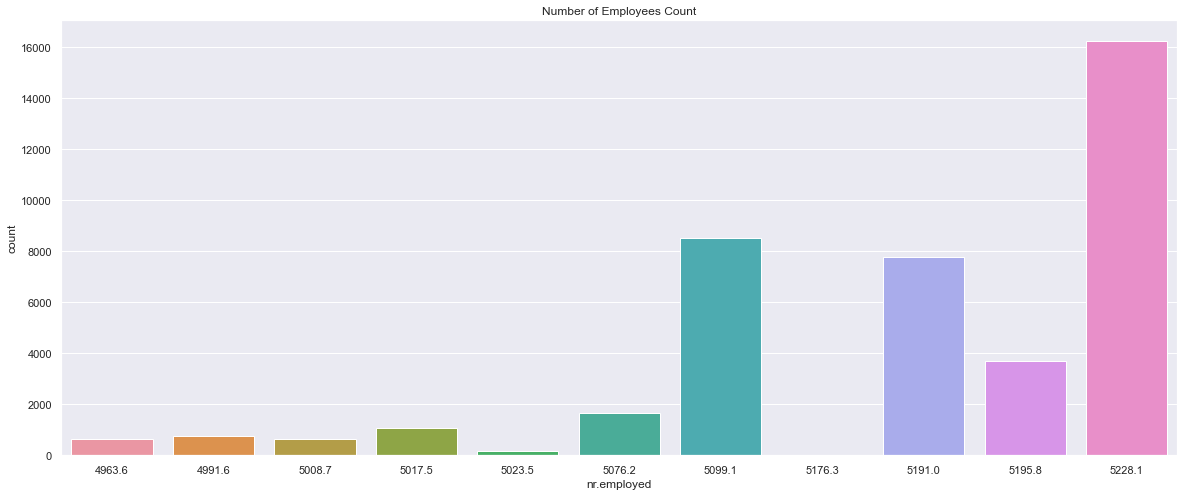

In [49]:
sns.countplot(data = df , x = 'nr.employed')
plt.title('Number of Employees Count')

Text(0.5, 1.0, 'Number of Employees Count based on Target')

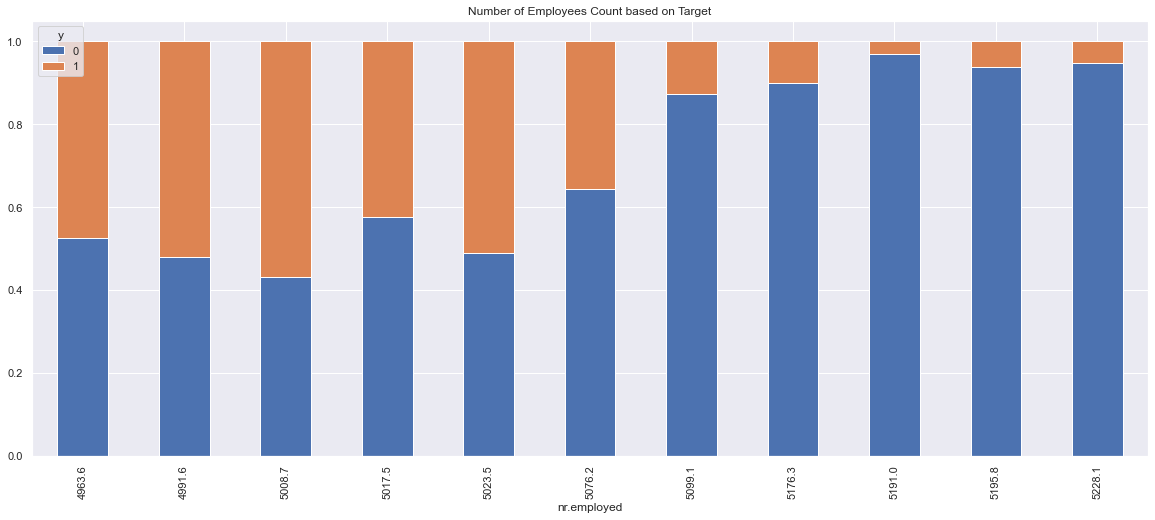

In [50]:
NE=pd.crosstab(df["nr.employed"],df['y'])
NE.div(NE.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Number of Employees Count based on Target')

#### Euro Interbank Offered Rate

Text(0.5, 1.0, 'Euribor3m Distribution based on target')

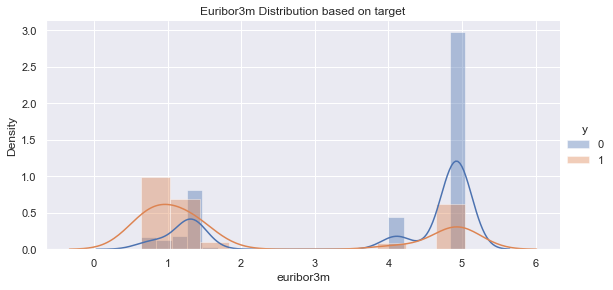

In [51]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'euribor3m').add_legend()
plt.title('Euribor3m Distribution based on target')

#### Consumer Confidence

Text(0.5, 1.0, 'Consumer Confidence Distribution based on target')

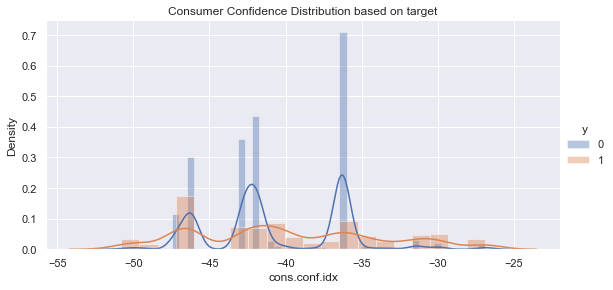

In [52]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.conf.idx').add_legend()
plt.title('Consumer Confidence Distribution based on target')

In [53]:
df['cons.conf.idx'].unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

#### Consumer Price

Text(0.5, 1.0, 'Consumer Confidence Index Distribution based on target')

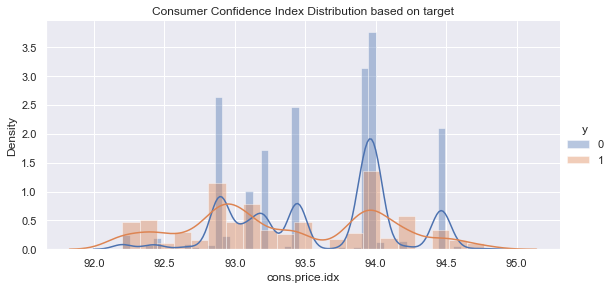

In [54]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.price.idx').add_legend()
plt.title('Consumer Confidence Index Distribution based on target')

#### Employment Variation Rate

Text(0.5, 1.0, 'Employee Variation Rate Distribution based on target')

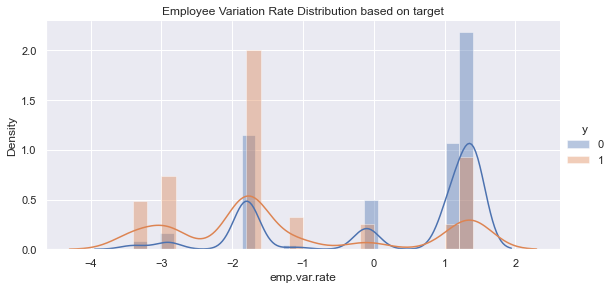

In [55]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'emp.var.rate').add_legend()
plt.title('Employee Variation Rate Distribution based on target')

In [56]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

#### Previous

Text(0.5, 1.0, 'Previous Count')

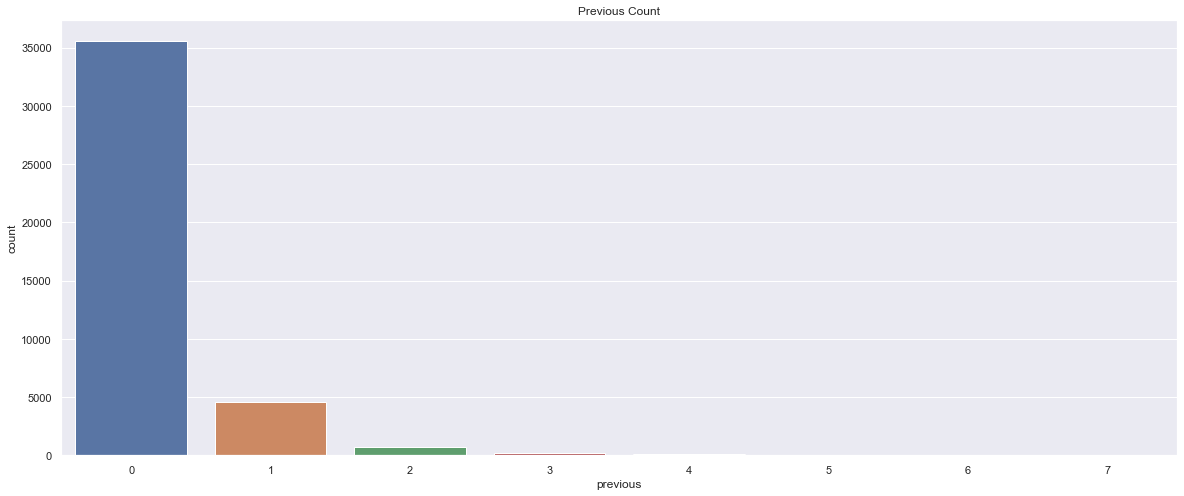

In [57]:
sns.countplot(data = df , x = 'previous')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Previous Count')

Text(0.5, 1.0, 'Previous Count based on Target')

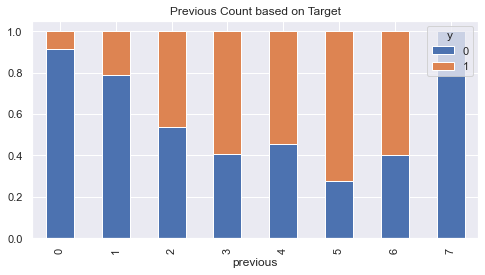

In [58]:
Previous=pd.crosstab(df["previous"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Previous Count based on Target')

Based on the visualization above it is shown that the maximum number of contact before this campaign is 7 times.

#### pdays

Text(0.5, 1.0, 'Pdays Box Plot')

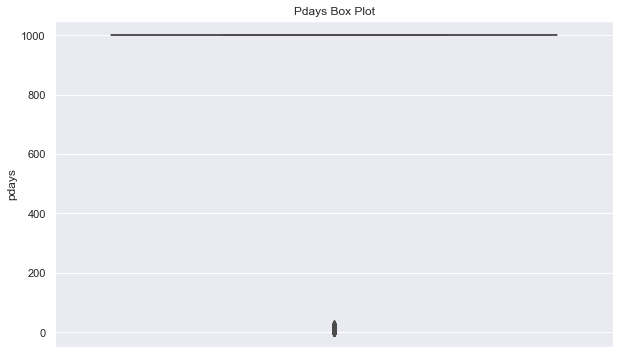

In [59]:
sns.boxplot(data = df , y = 'pdays')
plt.title('Pdays Box Plot')

Text(0.5, 1.0, 'Pdays Count')

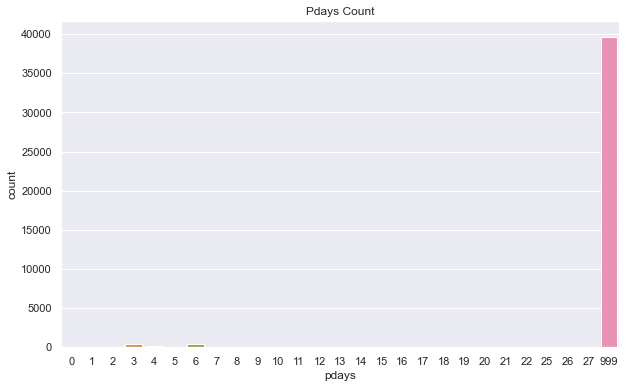

In [60]:
sns.countplot(data = df , x = 'pdays')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays Count based on Target')

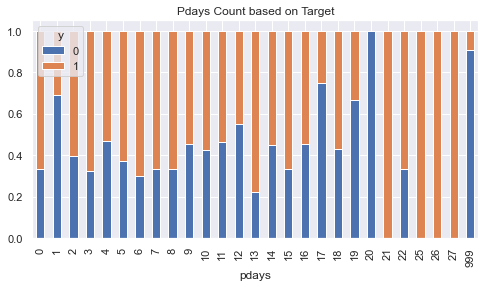

In [61]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(12,6)})
plt.title('Pdays Count based on Target')

In [62]:
df['pdays'].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

Based on the visualization above it is shown that there is a huge between 27 to 999, this happened because 999 is a label to show that the user never been offered before.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot')

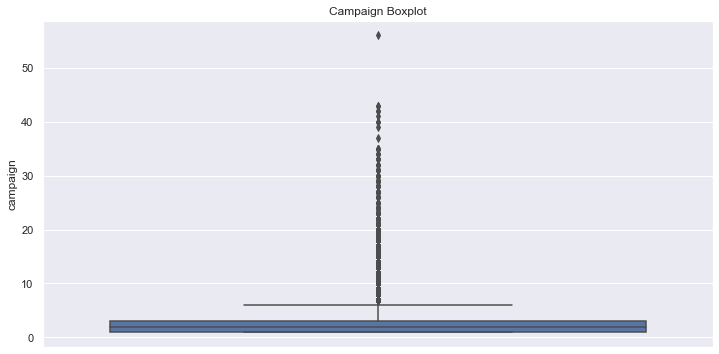

In [63]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot')

Text(0.5, 1.0, 'Pdays Count')

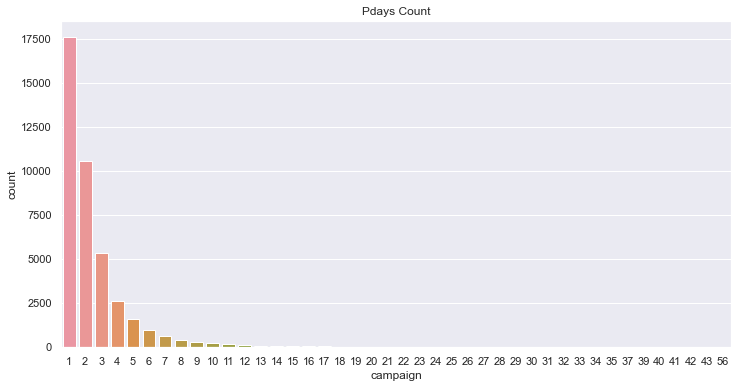

In [64]:
sns.countplot(data = df , x = 'campaign')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays count based on target')

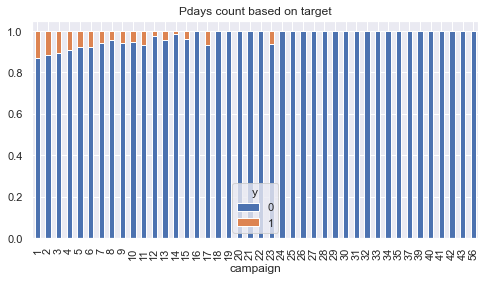

In [65]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

#### Age

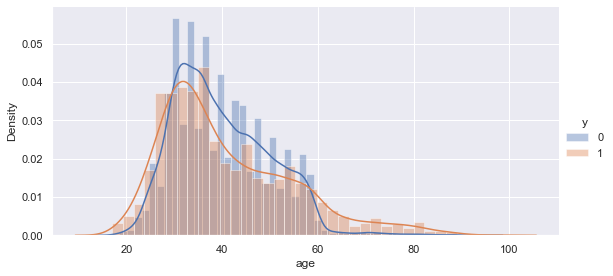

In [66]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'age').add_legend()

#### Duration

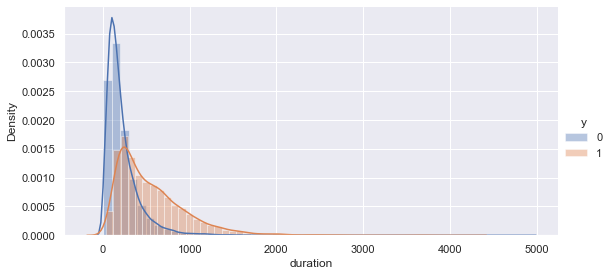

In [67]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'duration').add_legend()

Based on the visualization above it is shown that the longer the duration the higher to chance for a user to open a term deposit.

# Preprocessing

In [68]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Handling Duplicate

In [69]:
df.drop_duplicates(keep='last',inplace=True)

Deleting duplicated and only keeping the last occurance.

In [70]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


### Handling Missing Values

In [71]:
df.drop(columns = 'default',inplace=True)

Dropping default column 

In [72]:
df.dropna(inplace=True)

Removing rows with Nan values

In [73]:
df.shape

(38234, 20)

### Feature Engineering

In [74]:
df.drop(columns= ['duration'],inplace=True)

Dropping Duration Column to provide more realistic model

#### Education

Grouping values in basic yearly with basic education.

*based on :  https://eurydice.eacea.ec.europa.eu/national-education-systems/portugal/organisation-education-system-and-its-structure*

In [75]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    df.loc[df['education'] == i, 'education'] = "basic.education"

df['education'].value_counts()

basic.education        12061
university.degree      11817
high.school             9241
professional.course     5097
illiterate                18
Name: education, dtype: int64

<AxesSubplot:xlabel='education', ylabel='count'>

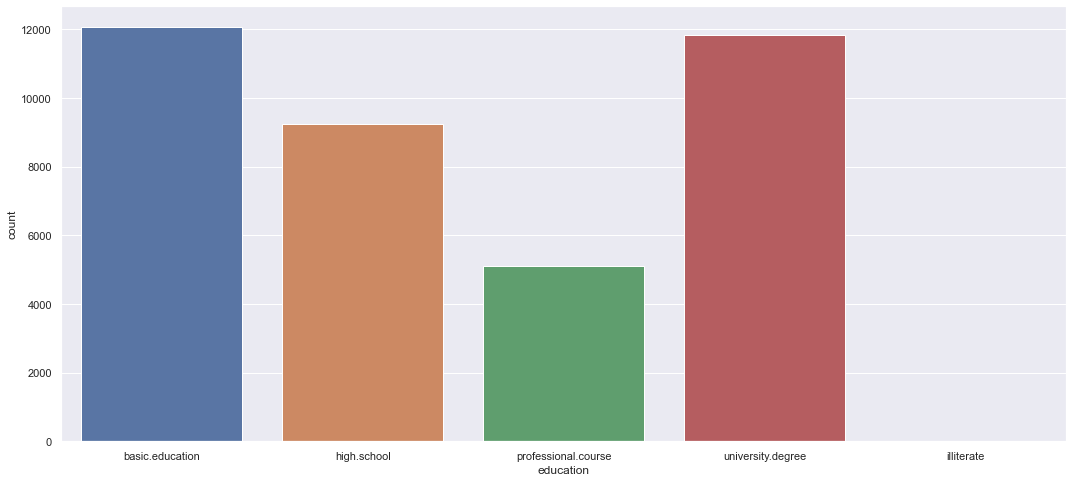

In [76]:
sns.countplot(data = df, x = 'education')

<AxesSubplot:xlabel='education'>

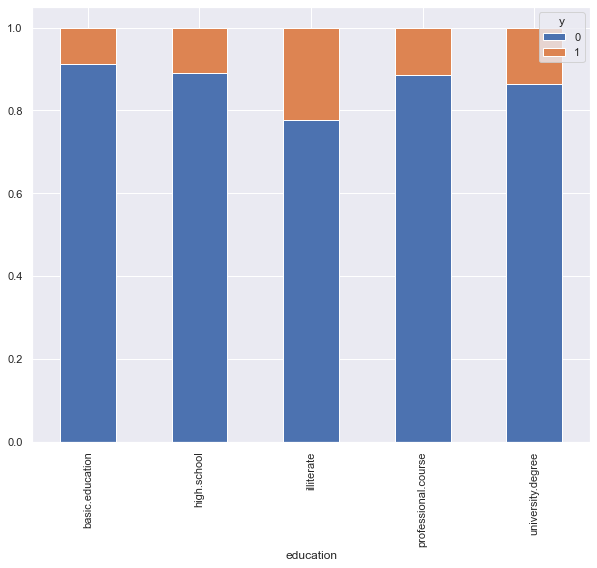

In [77]:
Education=pd.crosstab(df["education"],df['y'])
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))

Based on the visualization after frouping it still show that illiterate has the highest acceptance rate.

#### Pdays

In [78]:
df['pdays'] = ["Contacted" if v != 999 else 'Not Contacted' for v in df['pdays']]

Turning the values 999 to Not Contacted and others as Contacted.

In [79]:
df['pdays'].value_counts()

Not Contacted    36868
Contacted         1366
Name: pdays, dtype: int64

<AxesSubplot:xlabel='pdays', ylabel='count'>

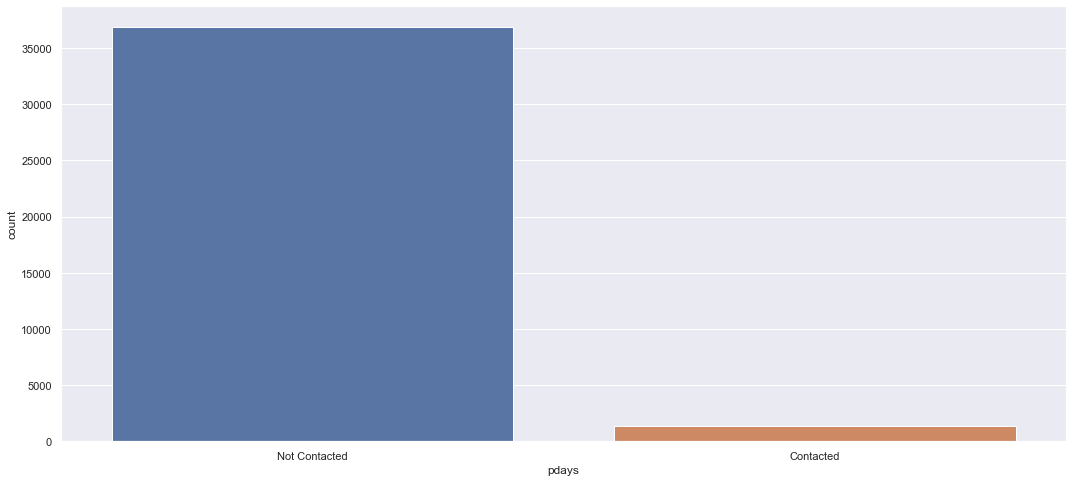

In [80]:
sns.countplot(data = df, x = 'pdays')

Text(0.5, 1.0, 'Pdays count based on target')

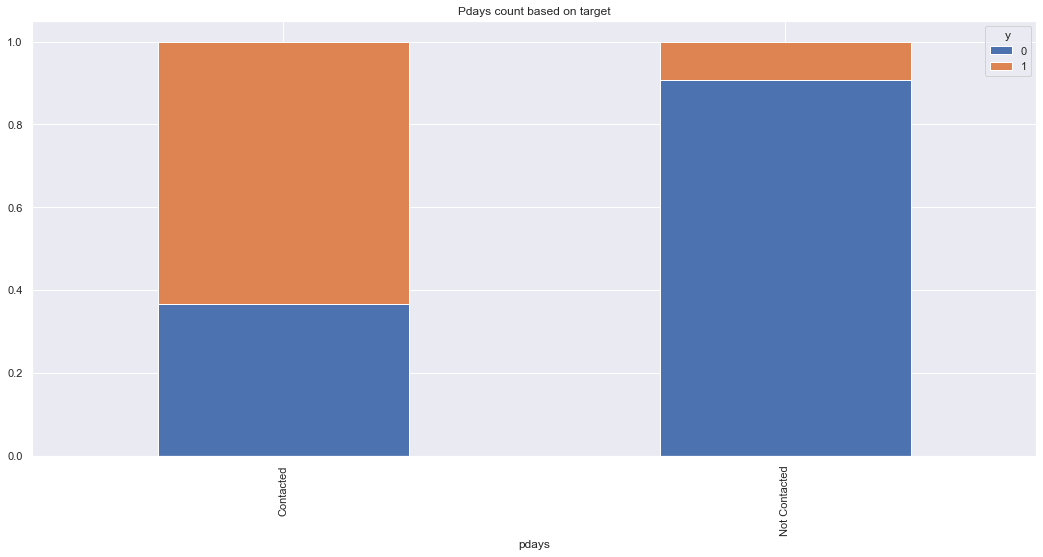

In [81]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

Based on the visualization above it shows that the one that has been contacted before has a higher chance to open a term deposit.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot with Outlier')

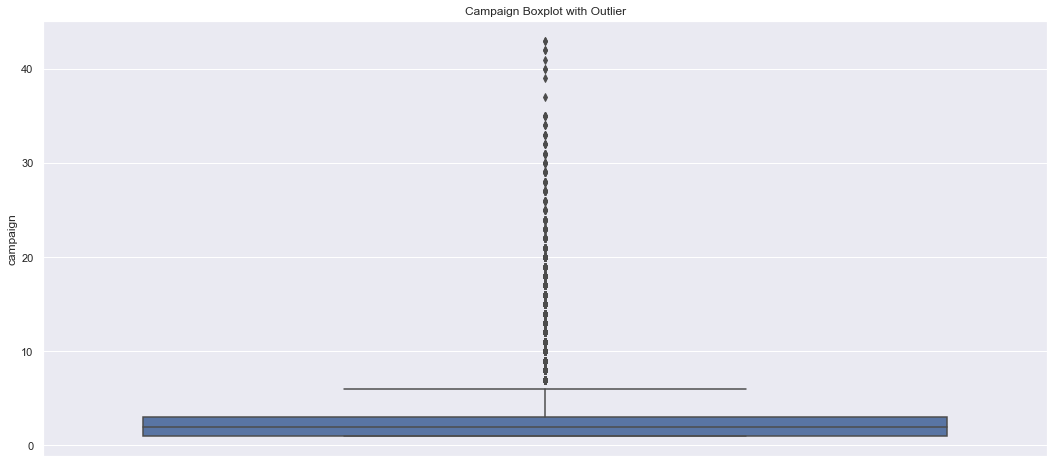

In [82]:
sns.boxplot(data=df , y = 'campaign')
plt.title('Campaign Boxplot with Outlier')

In [83]:
Q1 = df['campaign'].quantile(0.25)
Q3 = df['campaign'].quantile(0.75)
IQR = Q3 - Q1     

filter = (df['campaign'] >= Q1 - 1.5 * IQR) & (df['campaign'] <= Q3 + 1.5 *IQR)
df=df.loc[filter]

Text(0.5, 1.0, 'Campaign Boxplot without Outlier')

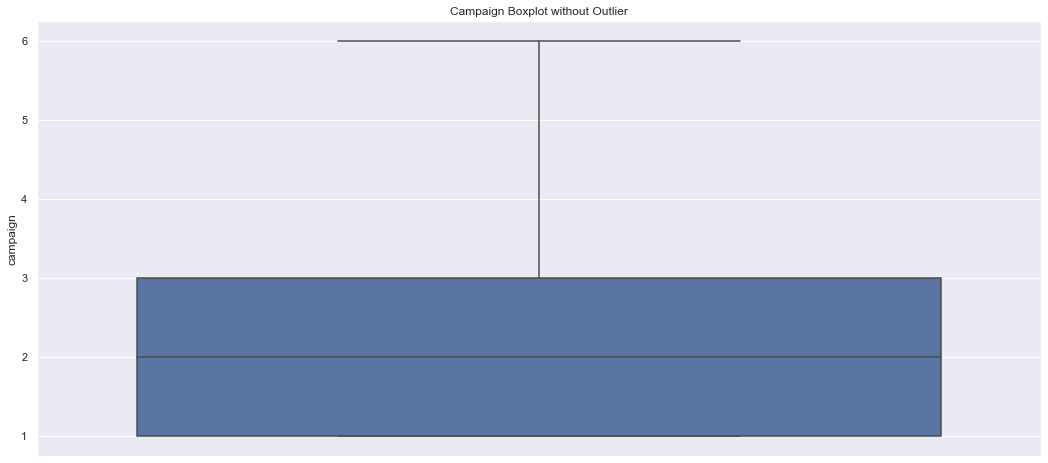

In [84]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot without Outlier')

<AxesSubplot:xlabel='campaign', ylabel='count'>

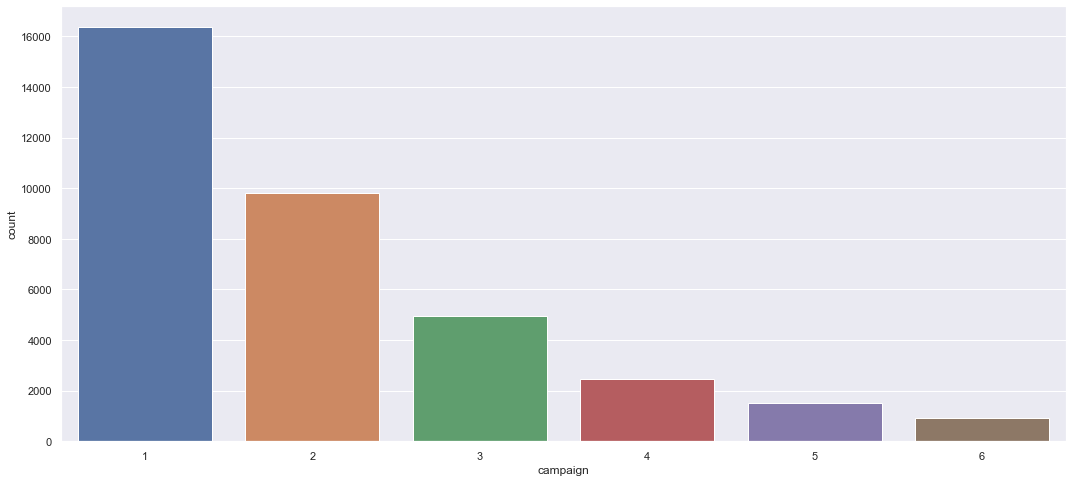

In [85]:
sns.countplot(data = df, x= 'campaign')

Text(0.5, 1.0, 'Campaign count based on target')

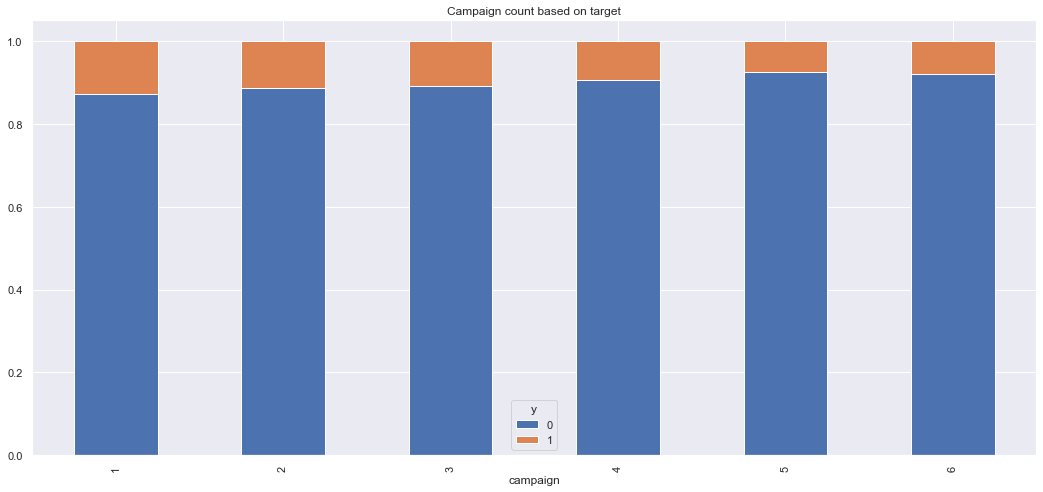

In [86]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Campaign count based on target')

In [87]:
df['campaign'] = df['campaign'].astype('O')

The outlier in campaign column is removed to minimize the amount of contact in order to make user open a term deposit.

#### Age

Melakuakan Grouping berdasarka rentang usia

In [88]:
df['age'].nunique()

77

In [89]:
#Grouping by Range
def age(dataframe):
    q1 = 20
    q2 = 30
    q3 = 40
    q4 = 50
    q5 = 60
    q6 = 70
    
    dataframe.loc[(dataframe['age'] < q1), 'age'] = 1
    dataframe.loc[(dataframe['age'] >= q1) & (dataframe['age'] < q2), 'age'] = 2
    dataframe.loc[(dataframe['age'] >= q2) & (dataframe['age'] < q3), 'age'] = 3
    dataframe.loc[(dataframe['age'] >= q3) & (dataframe['age'] < q4), 'age'] = 4
    dataframe.loc[(dataframe['age'] >= q4) & (dataframe['age'] < q5), 'age'] = 5
    dataframe.loc[(dataframe['age'] >= q5) & (dataframe['age'] < q6), 'age'] = 6
    dataframe.loc[(dataframe['age'] >= q6), 'age'] = 7
     
    return dataframe
age(df)

df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,housemaid,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,5,services,married,high.school,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,3,services,married,high.school,yes,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,4,admin.,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,5,services,married,high.school,no,yes,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [90]:
df['age'] = df['age'].astype('O')

<AxesSubplot:xlabel='age'>

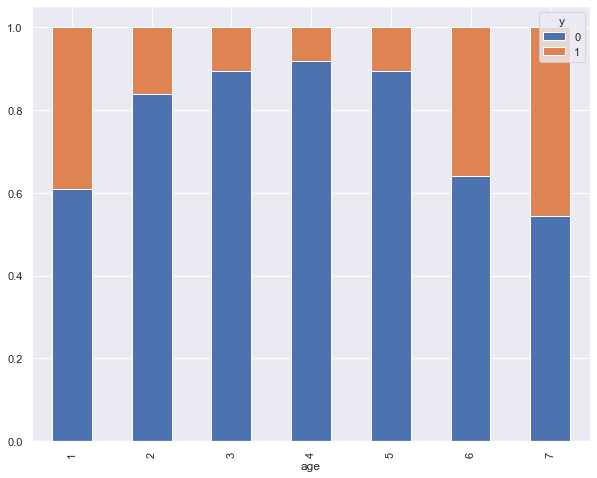

In [91]:
Age=pd.crosstab(df["age"],df['y'])
Age.div(Age.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))

Based on the visualization above it shows that the age below 20 and above 70 have the highest probability to open a term deposit.

In [92]:
# df.to_csv("E:\GitHub\Portugal-Telemarketing\data-clean.csv")

#### Encoding

In [93]:
lst_object = []

for i in df.columns:
    if df[i].dtype == 'O':
        lst_object.append([i,df[i].nunique(),list(df[i].drop_duplicates().sample(2).values)])
        
pd.DataFrame(data=lst_object,columns=['Columns', 'N Unique','Unique Sample']).sort_values(by=['N Unique']).reset_index()

,index,Columns,N Unique,Unique Sample
0,4,housing,2,"[no, yes]"
1,5,loan,2,"[no, yes]"
2,6,contact,2,"[telephone, cellular]"
3,10,pdays,2,"[Not Contacted, Contacted]"
4,2,marital,3,"[divorced, married]"
5,11,poutcome,3,"[failure, nonexistent]"
6,3,education,5,"[university.degree, professional.course]"
7,8,day_of_week,5,"[fri, tue]"
8,9,campaign,6,"[4, 2]"
9,0,age,7,"[4, 1]"


##### 

In [94]:
# Housing
df['housing'] = df['housing'].replace({'no':0,'yes':1})

# Loan
df['loan'] = df['loan'].replace({'no':0,'yes':1})

# Pdays
df['pdays'] = df['pdays'].replace({'Not Contacted':0,'Contacted':1})

In [95]:
df['education'].unique()

array(['basic.education', 'high.school', 'professional.course',
       'university.degree', 'illiterate'], dtype=object)

In [96]:
# Education
df['education'] = df['education'].replace({'illiterate':0,
                                           'basic.education':1,
                                           'high.school':2,
                                           'university.degree':3,
                                           'professional.course':4})


In [97]:
# Month
month_encoder = df['month'].value_counts().to_dict()
df['month'] = df['month'].map(month_encoder)

In [98]:
# Job
job_encoder = df['job'].value_counts().to_dict()
df['job'] = df['job'].map(job_encoder)

In [99]:
df = pd.get_dummies(df)

In [100]:
df.head()

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success
0,920,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,3503,2,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,3503,2,1,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,9333,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,3503,2,0,1,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [101]:
df.shape

(36014, 39)

In [102]:
df

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success
0,920,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,3503,2,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,3503,2,1,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,9333,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,3503,2,0,1,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1497,4,1,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
41184,8080,4,0,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
41185,1497,3,1,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
41186,5988,4,0,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


#### Scaling

In [103]:
# # change the range of Var Rate
# df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
# df['emp.var.rate'] = df['emp.var.rate'] * -1
# df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# # Multiply consumer index 
# df['cons.price.idx'] = (df['cons.price.idx'] * 10).astype('uint8')

# # change the sign (we want all be positive values)
# df['cons.conf.idx'] = df['cons.conf.idx'] * -1

# # re-scale variables
# df['nr.employed'] = np.log2(df['nr.employed']).astype('uint8')
# df['cons.price.idx'] = np.log2(df['cons.price.idx']).astype('uint8')
# df['cons.conf.idx'] = np.log2(df['cons.conf.idx']).astype('uint8')
# df['job'] = np.log2(df['job']).astype('uint8')
# df['month'] = np.log2(df['month']).astype('uint8')

# # less space
# df.euribor3m = df.euribor3m.astype('uint8')

data = df.drop('y', axis=1)
df_norm = (data-data.min())/(data.max()-data.min())
df_norm = pd.concat((df_norm, df.y), 1)
df = df_norm

In [104]:
df

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,0.029307,0.25,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.327334,0.50,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.327334,0.50,1.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,1.000000,0.25,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.327334,0.50,0.0,1.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.095881,1.00,1.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
41184,0.855429,1.00,0.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
41185,0.095881,0.75,1.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
41186,0.614053,1.00,0.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [105]:
df.shape

(36014, 39)

### Feature Selection

<AxesSubplot:>

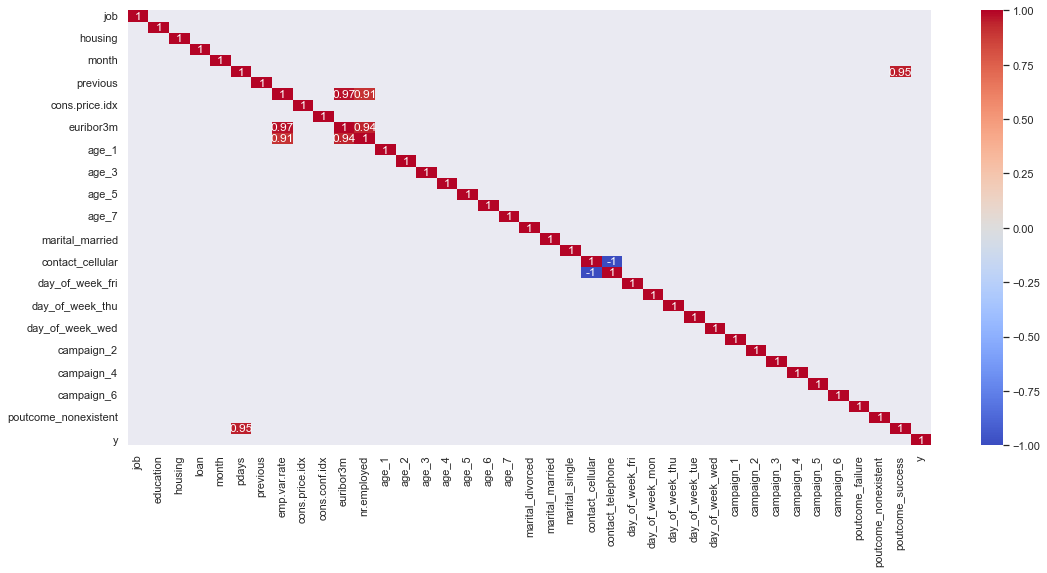

In [106]:
# create correlation matrix
corr = df.corr()

# create heatmap using seaborn
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=(corr.abs() < 0.90 ))


In [107]:
df.drop(columns=['nr.employed','cons.price.idx'],inplace=True)

In [108]:
X_rfecv = df.drop('y', axis=1)
target_rfecv = df['y']

rfc = lgb.LGBMClassifier(random_state=123)
rfecv = RFECV(estimator=rfc, step=1, scoring='f1_weighted')
rfecv = rfecv.fit(X_rfecv.values, target_rfecv.values)

Optimal number of features: 4


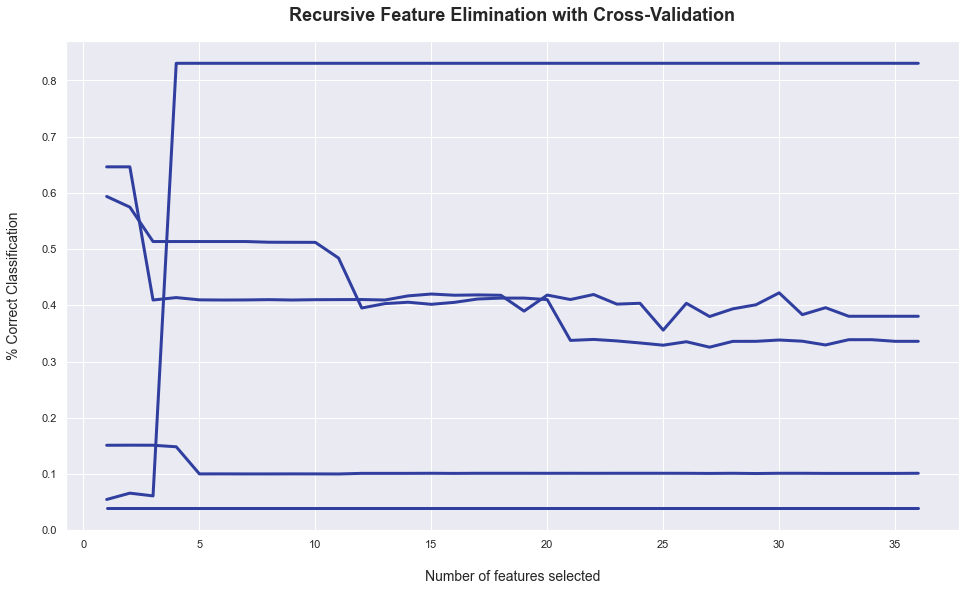

In [109]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [110]:
from numpy import array

mask = rfecv.get_support()
features = array(X_rfecv.columns) 
best_features = features[mask]
 
print("All features: ", X_rfecv.shape[1])
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

All features:  36
['job' 'education' 'housing' 'loan' 'month' 'pdays' 'previous'
 'emp.var.rate' 'cons.conf.idx' 'euribor3m' 'age_1' 'age_2' 'age_3'
 'age_4' 'age_5' 'age_6' 'age_7' 'marital_divorced' 'marital_married'
 'marital_single' 'contact_cellular' 'contact_telephone' 'day_of_week_fri'
 'day_of_week_mon' 'day_of_week_thu' 'day_of_week_tue' 'day_of_week_wed'
 'campaign_1' 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5'
 'campaign_6' 'poutcome_failure' 'poutcome_nonexistent' 'poutcome_success']
Selected best:  4
['job' 'education' 'month' 'euribor3m']


In [111]:
bank = df[best_features]

In [112]:
bank

,job,education,month,euribor3m
0,0.029307,0.25,1.000000,0.957379
1,0.327334,0.50,1.000000,0.957379
2,0.327334,0.50,1.000000,0.957379
3,1.000000,0.25,1.000000,0.957379
4,0.327334,0.50,1.000000,0.957379
...,...,...,...,...
41183,0.095881,1.00,0.305375,0.089322
41184,0.855429,1.00,0.305375,0.089322
41185,0.095881,0.75,0.305375,0.089322
41186,0.614053,1.00,0.305375,0.089322


# Modeling

In [113]:
x = df.drop(columns=['y'])
#x = bank
y = df['y']

In [114]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=123)

In [115]:
logreg = LogisticRegression(random_state = 123, class_weight='balanced')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=123,class_weight='balanced')
rf = RandomForestClassifier(random_state=123,class_weight='balanced')
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier(random_state=123,class_weight='balanced')
gbc = GradientBoostingClassifier(random_state=123)
gnb = GaussianNB()
bc = BaggingClassifier(random_state=123)
ab = AdaBoostClassifier(random_state=123)

In [116]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1_weighted')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier'],'mean f1 weighted':rata,'sdev':std}).set_index('model').sort_values(by='mean f1 weighted',ascending=False)

,mean f1 weighted,sdev
model,,
Gradient Boosting Classifier,0.876548,0.001047
XGBoost,0.876545,0.001267
Adaboost Classifier,0.873937,0.001659
KNN,0.864876,0.002457
Bagging Classifier,0.864453,0.002480
Random Forest,0.861569,0.001961
Naive Bayes,0.856010,0.002861
LightGBM,0.854328,0.003871
Decision Tree,0.833475,0.003613


In [117]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.95      0.81      0.88      6372
           1       0.32      0.67      0.43       831

    accuracy                           0.80      7203
   macro avg       0.63      0.74      0.65      7203
weighted avg       0.88      0.80      0.82      7203

KNN 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      6372
           1       0.57      0.24      0.34       831

    accuracy                           0.89      7203
   macro avg       0.74      0.61      0.64      7203
weighted avg       0.87      0.89      0.87      7203

Decision Tree 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      6372
           1       0.29      0.34      0.31       831

    accuracy                           0.83      7203
   macro avg       0.60      0.62      0.61      7203
weighted avg       0.84      0

,roc_auc score
model,
Gradient Boosting Classifier,0.806545
LightGBM,0.802658
Adaboost Classifier,0.798795
XGBoost,0.795062
Logistic Regression,0.787220
Random Forest,0.770353
Naive Bayes,0.760964
Bagging Classifier,0.743916
KNN,0.698349


In [118]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='weighted')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [119]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)

In [120]:
data = x_train
target = y_train

In [121]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_random_oversampling = []
validation_errors_with_random_oversampling = []

train_errors_with_smote_oversampling = []
validation_errors_with_smote_oversampling = []

train_errors_with_random_undersampling = []
validation_errors_with_random_undersampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler(random_state = 123, sampling_strategy=0.6)

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)
    
    smot = SMOTE(random_state = 123, sampling_strategy=0.6)

    X_smote, Y_smote = smot.fit_resample(X_train, Y_train)
    
    rus = RandomUnderSampler(random_state = 123, sampling_strategy=0.6)

    X_rus, Y_rus = rus.fit_resample(X_train, Y_train)

    # instantiate model
    estimator=Pipeline([
        ('model',gbc)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_random_oversampling, val_error_with_random_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    train_error_with_smote_oversampling, val_error_with_smote_oversampling = calc_metrics( X_smote, Y_smote, X_val, Y_val, estimator)
    train_error_with_random_undersampling, val_error_with_random_undersampling = calc_metrics(X_rus, Y_rus, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_random_oversampling.append(train_error_with_random_oversampling)
    validation_errors_with_random_oversampling.append(val_error_with_random_oversampling)
    
    train_errors_with_smote_oversampling.append(train_error_with_smote_oversampling)
    validation_errors_with_smote_oversampling.append(val_error_with_smote_oversampling)
    
    train_errors_with_random_undersampling.append(train_error_with_random_undersampling)
    validation_errors_with_random_undersampling.append(val_error_with_random_undersampling)

In [122]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.903660,0.896253,0.803626,0.832090,0.882948,0.871299,0.262947,0.207207,0.729379,0.663462
1,0.903085,0.898299,0.809194,0.783788,0.882865,0.876323,0.266867,0.237952,0.715309,0.663866
2,0.903278,0.893787,0.807399,0.797733,0.883244,0.873208,0.269205,0.240964,0.715808,0.597015
3,0.903625,0.897605,0.806001,0.816309,0.883227,0.875479,0.266199,0.234940,0.725205,0.655462
4,0.903432,0.901423,0.805885,0.799779,0.882912,0.881461,0.264529,0.265060,0.723949,0.687500
5,0.902815,0.902117,0.809667,0.788563,0.882185,0.880616,0.261945,0.252252,0.715982,0.717949
6,0.903239,0.895869,0.809922,0.794419,0.882781,0.875188,0.264617,0.246246,0.720000,0.625954
7,0.902738,0.901076,0.811576,0.781762,0.882059,0.881285,0.261276,0.267267,0.715462,0.684615
8,0.903085,0.900382,0.808007,0.797964,0.882397,0.879264,0.261945,0.252252,0.720588,0.688525
9,0.902661,0.901076,0.808692,0.798504,0.881198,0.878251,0.253258,0.237237,0.723973,0.718182


In [123]:
listItem = []

for tr,val in zip(train_errors_with_random_oversampling,validation_errors_with_random_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.787312,0.870229,0.817985,0.836161,0.779050,0.876662,0.585641,0.570571,0.793053,0.451306
1,0.782762,0.867060,0.819717,0.789252,0.773672,0.873214,0.572269,0.545181,0.790583,0.438257
2,0.780500,0.864283,0.818881,0.798368,0.771352,0.873093,0.569653,0.593373,0.786101,0.434879
3,0.784070,0.865672,0.817490,0.815483,0.775197,0.874037,0.575830,0.590361,0.791529,0.438479
4,0.784424,0.857688,0.816752,0.804766,0.775948,0.867356,0.580626,0.575301,0.788746,0.415217
5,0.786806,0.871572,0.818540,0.790803,0.778790,0.877562,0.588069,0.567568,0.789715,0.455422
6,0.787378,0.875738,0.822128,0.788860,0.778634,0.880394,0.580148,0.558559,0.797682,0.468514
7,0.787024,0.859771,0.818688,0.779260,0.778579,0.867651,0.583273,0.546547,0.794123,0.418391
8,0.784735,0.871919,0.818476,0.798874,0.776187,0.877574,0.580076,0.561562,0.790083,0.456098
9,0.783591,0.867407,0.816192,0.798944,0.774602,0.874611,0.574117,0.573574,0.791525,0.443155


In [124]:
listItem = []

for tr,val in zip(train_errors_with_smote_oversampling,validation_errors_with_smote_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.900646,0.890354,0.944891,0.823195,0.899272,0.881929,0.810043,0.378378,0.915264,0.536170
1,0.898221,0.892051,0.944264,0.772288,0.896768,0.885397,0.805247,0.409639,0.913069,0.541833
2,0.898248,0.888580,0.945553,0.794161,0.896682,0.882864,0.801395,0.412651,0.916784,0.520913
3,0.899011,0.882680,0.945046,0.809525,0.897648,0.877535,0.809026,0.400602,0.911719,0.488971
4,0.900918,0.886845,0.945477,0.801690,0.899605,0.883314,0.812441,0.442771,0.913772,0.510417
5,0.900515,0.887886,0.944380,0.776145,0.899069,0.879998,0.807368,0.378378,0.917430,0.520661
6,0.899016,0.885804,0.945238,0.780658,0.897589,0.878991,0.806787,0.387387,0.913827,0.507874
7,0.900624,0.886151,0.945853,0.768795,0.899243,0.881177,0.809766,0.417417,0.915469,0.509158
8,0.901332,0.892051,0.945120,0.779400,0.899855,0.883246,0.806932,0.378378,0.920126,0.547826
9,0.899561,0.892051,0.945103,0.798623,0.898092,0.883452,0.805770,0.381381,0.916295,0.547414


In [125]:
listItem = []

for tr,val in zip(train_errors_with_random_undersampling,validation_errors_with_random_undersampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.788372,0.865718,0.818980,0.835419,0.779948,0.873327,0.584698,0.573574,0.796903,0.438073
1,0.788702,0.857688,0.818230,0.788140,0.780946,0.866614,0.592852,0.557229,0.791351,0.412946
2,0.786573,0.863936,0.821374,0.792570,0.778095,0.872227,0.582498,0.578313,0.793449,0.432432
3,0.785822,0.869143,0.815575,0.811680,0.776358,0.876580,0.570808,0.587349,0.800843,0.448276
4,0.786448,0.860465,0.820770,0.802570,0.777863,0.870297,0.581162,0.596386,0.794158,0.424893
5,0.783862,0.870878,0.820135,0.793232,0.775637,0.876643,0.583027,0.558559,0.785329,0.452555
6,0.787871,0.871225,0.825549,0.792638,0.778840,0.877546,0.577347,0.573574,0.801484,0.454762
7,0.786242,0.858383,0.821137,0.783372,0.778123,0.866985,0.586368,0.555556,0.789474,0.415730
8,0.783110,0.871225,0.815023,0.797692,0.775059,0.877421,0.584364,0.570571,0.782200,0.454545
9,0.786117,0.863589,0.817490,0.800184,0.778375,0.871691,0.590712,0.573574,0.785778,0.432127


In [126]:
for rep in validation_errors_with_smote_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2549
           1       0.54      0.38      0.44       333

    accuracy                           0.89      2882
   macro avg       0.73      0.67      0.69      2882
weighted avg       0.88      0.89      0.88      2882

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2549
           1       0.54      0.41      0.47       332

    accuracy                           0.89      2881
   macro avg       0.73      0.68      0.70      2881
weighted avg       0.88      0.89      0.89      2881

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2549
           1       0.52      0.41      0.46       332

    accuracy                           0.89      2881
   macro avg       0.72      0.68      0.70      2881
weighted avg       0.88      0.89      0.88      2881

              preci

### Hyperparameter Tuning

In [127]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 123
    }
    
    # Train a Gradient Boosting Classifier with the current set of hyperparameters
    gbc = GradientBoostingClassifier(**params)
    gbc.fit(X_smote, Y_smote)
    
    # Evaluate the model on the validation set and return the accuracy
    y_pred = gbc.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=250)

# Print the best hyperparameters and accuracy
best_params = study.best_params
best_f1 = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_f1)

[I 2023-05-19 11:19:25,204] A new study created in memory with name: no-name-59d210a7-6a23-49d5-90c0-8b6c36a0d0f1
[I 2023-05-19 11:21:59,319] Trial 0 finished with value: 0.870936793789404 and parameters: {'n_estimators': 299, 'max_depth': 23, 'learning_rate': 0.04614312038417761, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.870936793789404.
[I 2023-05-19 11:22:07,659] Trial 1 finished with value: 0.8304782767769413 and parameters: {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.0015332979246919344, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.870936793789404.
[I 2023-05-19 11:22:27,807] Trial 2 finished with value: 0.8786693887844316 and parameters: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.003473970315966309, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.8786693887844316.
[I 2023-05-19 11:23:17,588]

Best Hyperparameters: {'n_estimators': 627, 'max_depth': 8, 'learning_rate': 0.004911670775661831, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Accuracy: 0.8889688973810758


In [128]:
print(f"\tBest value (f1_weighted): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (f1_weighted): 0.88897
	Best params:
		n_estimators: 627
		max_depth: 8
		learning_rate: 0.004911670775661831
		min_samples_split: 5
		min_samples_leaf: 2
		max_features: sqrt


In [129]:
study.best_params

{'n_estimators': 627,
 'max_depth': 8,
 'learning_rate': 0.004911670775661831,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [130]:
best = GradientBoostingClassifier(**study.best_params)

In [131]:
best

GradientBoostingClassifier(learning_rate=0.004911670775661831, max_depth=8,
                           max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=5, n_estimators=627)

In [132]:
best_model = best.fit(X_smote,Y_smote)

In [133]:
estimator=Pipeline([
    ('oversampling',smot),
    ('model',gbc)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling',
                 SMOTE(random_state=123, sampling_strategy=0.6)),
                ('model', GradientBoostingClassifier(random_state=123))])

In [134]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.7957563664135285
ROC AUC Score Tuned LGBM :  0.8012726594917747


In [135]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      6372
           1       0.53      0.44      0.48       831

    accuracy                           0.89      7203
   macro avg       0.73      0.69      0.71      7203
weighted avg       0.88      0.89      0.89      7203

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      6372
           1       0.53      0.46      0.49       831

    accuracy                           0.89      7203
   macro avg       0.73      0.70      0.71      7203
weighted avg       0.88      0.89      0.89      7203



### Threshold Tuning

In [136]:
best_model.fit(x_train,y_train)
y_pred = best_model.predict_proba(x_test)
y_pred = y_pred[:,1]

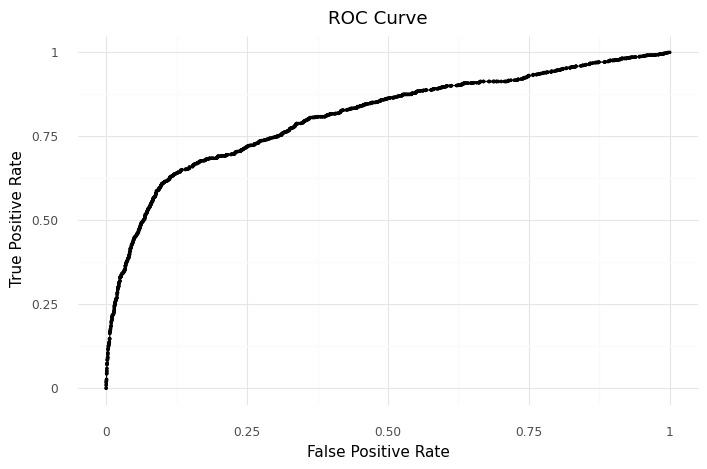

<ggplot: (135136710819)>

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.1174 with G-Mean: 0.7508
FPR: 0.1325, TPR: 0.6498


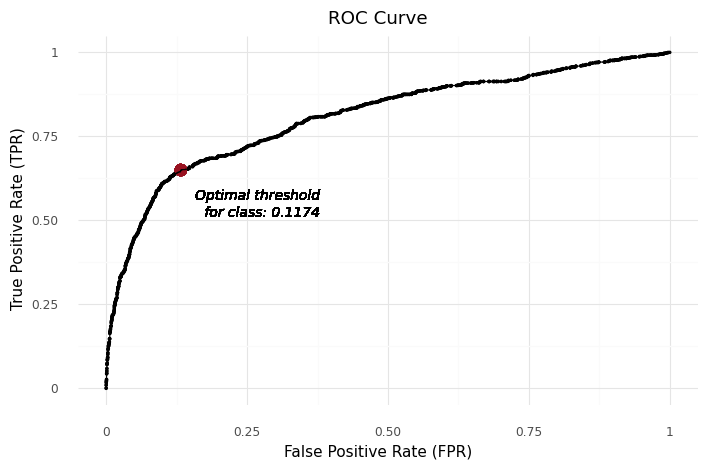

<ggplot: (135136763938)>

In [138]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.1272 with Youden J statistic: 0.749
FPR: 0.1204, TPR: 0.6378


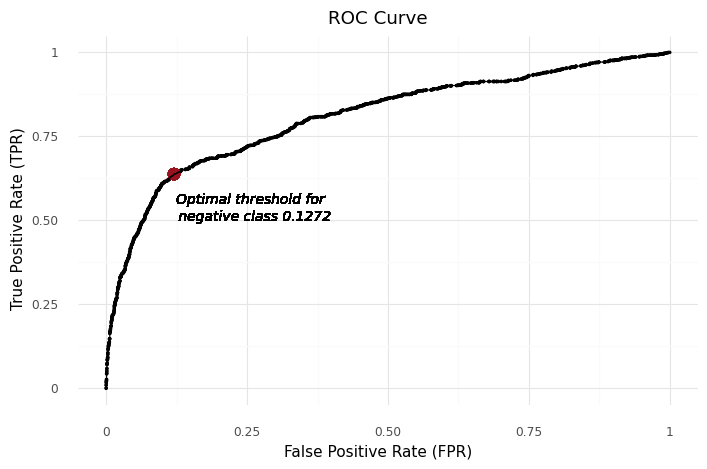

<ggplot: (135144116113)>

In [139]:
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

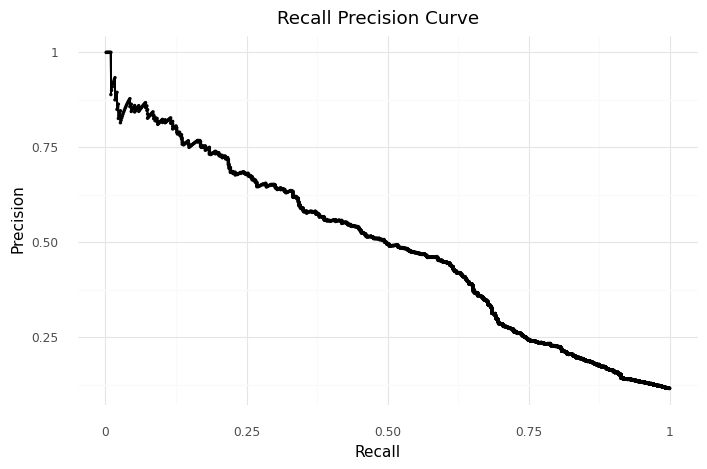

<ggplot: (135152558315)>

In [140]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 0.1882 with F-Score: 0.5175
Recall: 0.5872, Precision: 0.4626


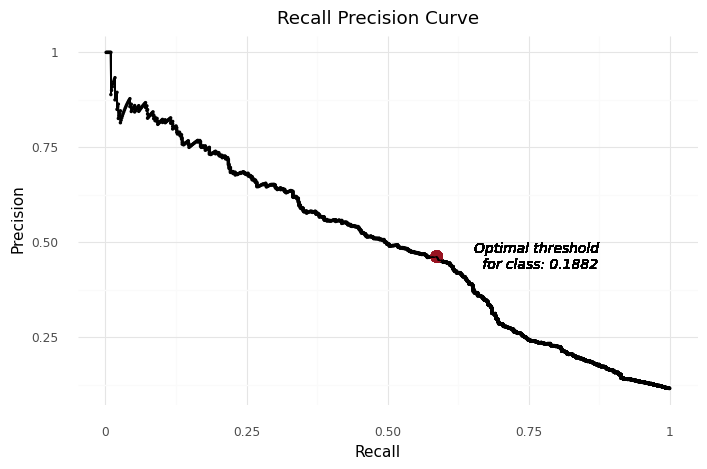

<ggplot: (135152396725)>

In [141]:
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 10000
Best Threshold: 0.1875 with F-Score: 0.5175


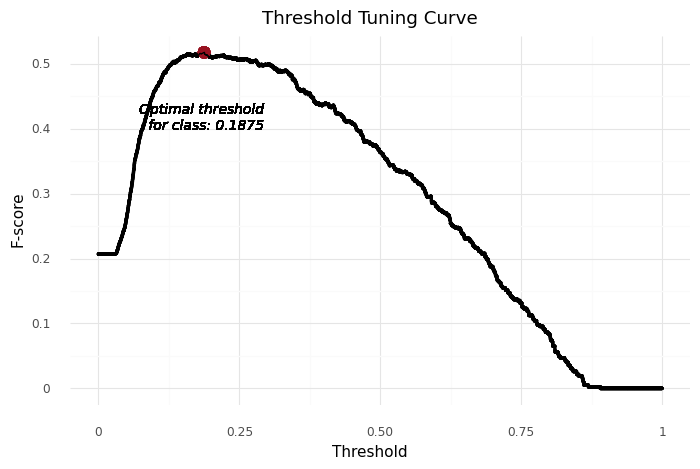

<ggplot: (135152432008)>

In [142]:
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

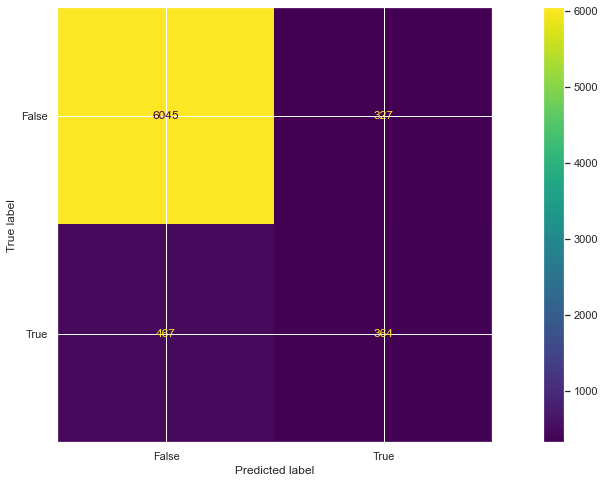

In [143]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_default)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [144]:
print(classification_report(y_test,y_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6372
           1       0.53      0.46      0.49       831

    accuracy                           0.89      7203
   macro avg       0.73      0.70      0.71      7203
weighted avg       0.88      0.89      0.89      7203



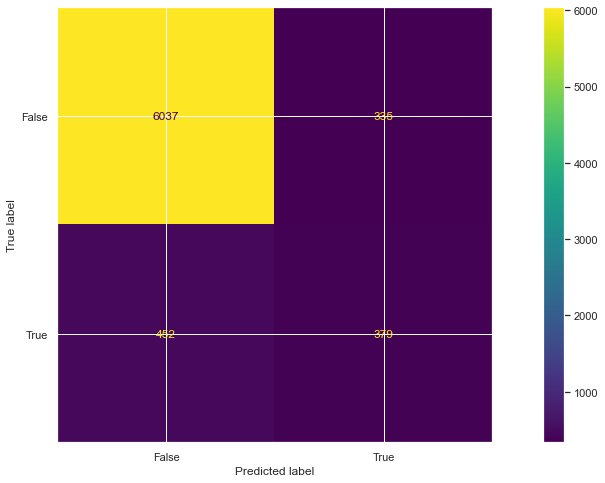

In [145]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_tuned)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [146]:
decisions = (best_model.predict_proba(x_test)[:,1] >= thresholdOpt).astype(int)

In [147]:
print(roc_auc_score(y_test,decisions))

0.7491306165738645


In [148]:
print(classification_report(y_test,decisions))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      6372
           1       0.46      0.59      0.52       831

    accuracy                           0.87      7203
   macro avg       0.70      0.75      0.72      7203
weighted avg       0.89      0.87      0.88      7203



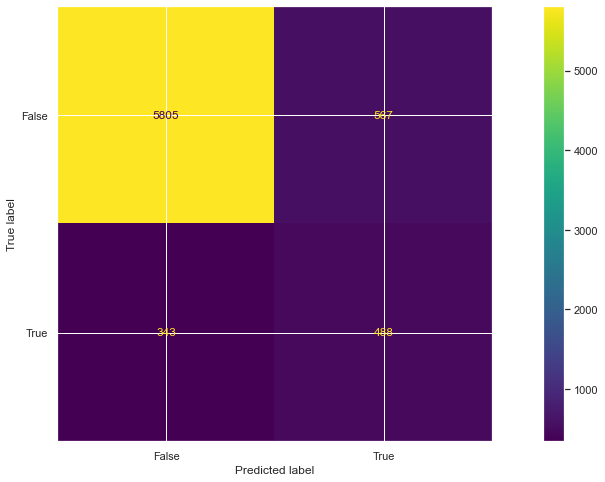

In [149]:
confusion_matrix = metrics.confusion_matrix(y_test, decisions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [179]:
print("Base Model : ")
matthews_corrcoef(y_test, y_pred_default)

Base Model : 


0.4194938175018489

In [180]:
print("After Hyperparameter Tuning : ")
matthews_corrcoef(y_test, y_pred_tuned)

After Hyperparameter Tuning : 


0.43136752378983345

In [181]:
print("After Hyperparameter Tuning and Threshold Optimization : ")
matthews_corrcoef(y_test, decisions)

After Hyperparameter Tuning and Threshold Optimization : 


0.45019672851120895

### Feature Importances

Let's see which features that is affecting the user to open a term deposit or not.

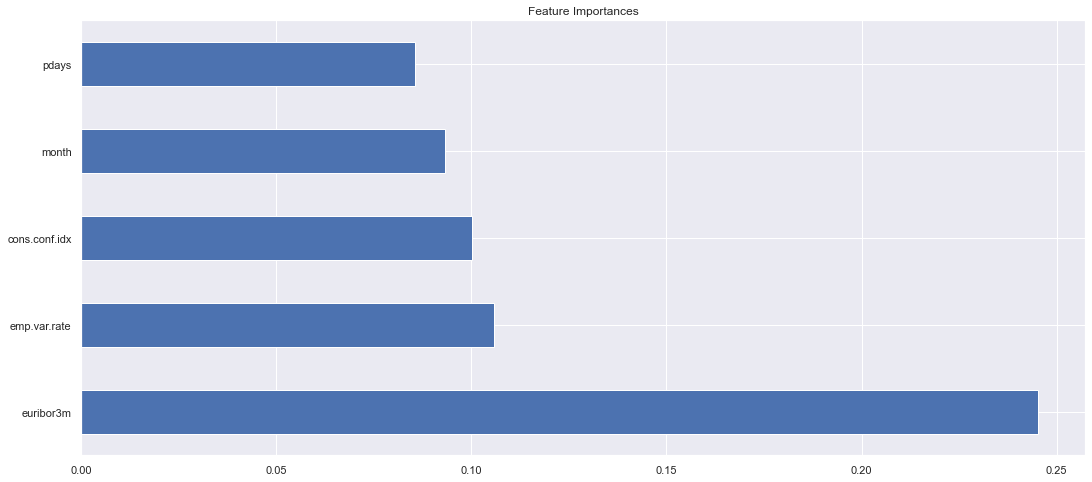

In [153]:
coef1 = pd.Series(best_model.feature_importances_,index = data.columns).sort_values(ascending = False).head()
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Based on the visualization above, euribor3m has the most influence in determining wheter to open a term deposit or not.

### Sorting user based on Acceptance rate

In [193]:
decisions_sorted = sorted(best_model.predict_proba(x_test)[:,1],reverse=True)

In [211]:
df_decision = pd.DataFrame(best_model.predict_proba(x_test)[:,1],columns=['Probs'])

In [212]:
df_decision

,Probs
0,0.034567
1,0.058976
2,0.056034
3,0.050294
4,0.171522
...,...
7198,0.092218
7199,0.034006
7200,0.048070
7201,0.056953


In [219]:
df_decision = df_decision[df_decision['Probs'] >= thresholdOpt]

In [221]:
df_decision.sort_values(by='Probs',ascending = False).head(int(len(df_decision) * 0.1))

,Probs
1031,0.890399
6432,0.869374
4295,0.861608
980,0.861337
4008,0.860347
...,...
3817,0.704233
4853,0.703228
6327,0.702926
7159,0.702188


Shows a table for top 10% user that has the highest probability to open a term deposit.

# Conclusion & Recomendation

Conclusion : 
 * The model is helping the marketing by the calculation below : 
     * if we assume the cost per minute of making telemarketing is **19cent/0.19EUR** based on https://digital-strategy.ec.europa.eu/en/faqs/calling-and-texting-other-eu-countries-questions-answers
     * the average call time is 5 minute, so the cost per user is **5 x 0.19 = 0.95EUR**
     * before using the model the number of opened account vs number of contact is = **11%**, so we needed a total of **36014 x 0.95EUR = 34.213,3EUR**
     * after using the model we can also sort the user based on it's predicted percentage, let's say after adding the degree and uncertainty we needed the top 15% user
     * The calculation became **5403 x 0.95EUR = 5132EUR**
     * The model could cut down the cost to about **15%** of it's original cost
 * It shows on the visualization of column job and age that those who are in below 20 or student and after 60 or retired are more likely to open a term deposit.
 * Those who joins in the previous campaign is more likely to join in the current campaign (opening a term deposit)
 * The recomended interest rate by European bank became the most important factor for a user to open a term deposit or not.

Business Recomendation : 

* To first contact those that are in table for top 10% user that has the highest probability to open a term deposit.

Classification Model Future Improvement Recomendation :

* The dataset it self is highly imbalanced, so adding more data in the minority class should helps the model to predict better.
* Adding more features that could explain more about the characteristics of the user, such as credit score, balance and etc.
* Explore more model for benchmarking purposes and it's hyperparameter tuning.